In [2]:
from scipy.optimize import curve_fit
from glob import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', quality=100)
plt.rcParams["figure.figsize"] = (10,5)

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use(['manuscript'])

In [17]:
def hill_equation(lig_conc, A, ic50, n, baseline_activity):
    return baseline_activity - A / (1 + (ic50 / lig_conc) ** n) #(conc ** n) / (ic50 ** n + conc ** n)

In [2]:
def ic50_equation_fraction_inhibited(lig_conc, ic50, n):
    return 1 / (1 + (ic50 / lig_conc) ** n)

In [3]:
def ic50_equation_relative_activity(lig_conc, ic50, n):
    return 1 / (1 + (lig_conc / ic50) ** n)

In [32]:
def ic50_equation_fixed_n(lig_conc, ic50):
    return 1 / (1 + (lig_conc / ic50))

# MYH7b

In [122]:
# Load in data
myh7b_experiments = [
    pd.read_csv(f)
    for f in glob('/mnt/bowmore/bowmore/ameller/projects/experimental-data/7b_actin_control_*.csv')
]

# experimental_data = pd.read_csv('/mnt/bowmore/bowmore/ameller/projects/experimental-data/'
#                                 'myh7b-bleb-inhibition-atpase.csv')
# experimental_data

In [123]:
normalized_experiments = []
for df in myh7b_experiments:
    control_value = float(df.loc[df['Concentration'] == 'Control']['ATPase'])
    df2 = df.loc[df['Concentration'] != 'Control']
    df2['Concentration'] = pd.to_numeric(df2['Concentration'])
    df2['r_ATPase'] = df2['ATPase'] - control_value
    df2['n_ATPase'] = df2['r_ATPase'] / float(df2.loc[df2['Concentration'] == 0]['r_ATPase'])
    normalized_experiments.append(df2)

/home/artur/anaconda3/envs/enspara/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/artur/anaconda3/envs/enspara/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/artur/anaconda3/envs/enspara/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

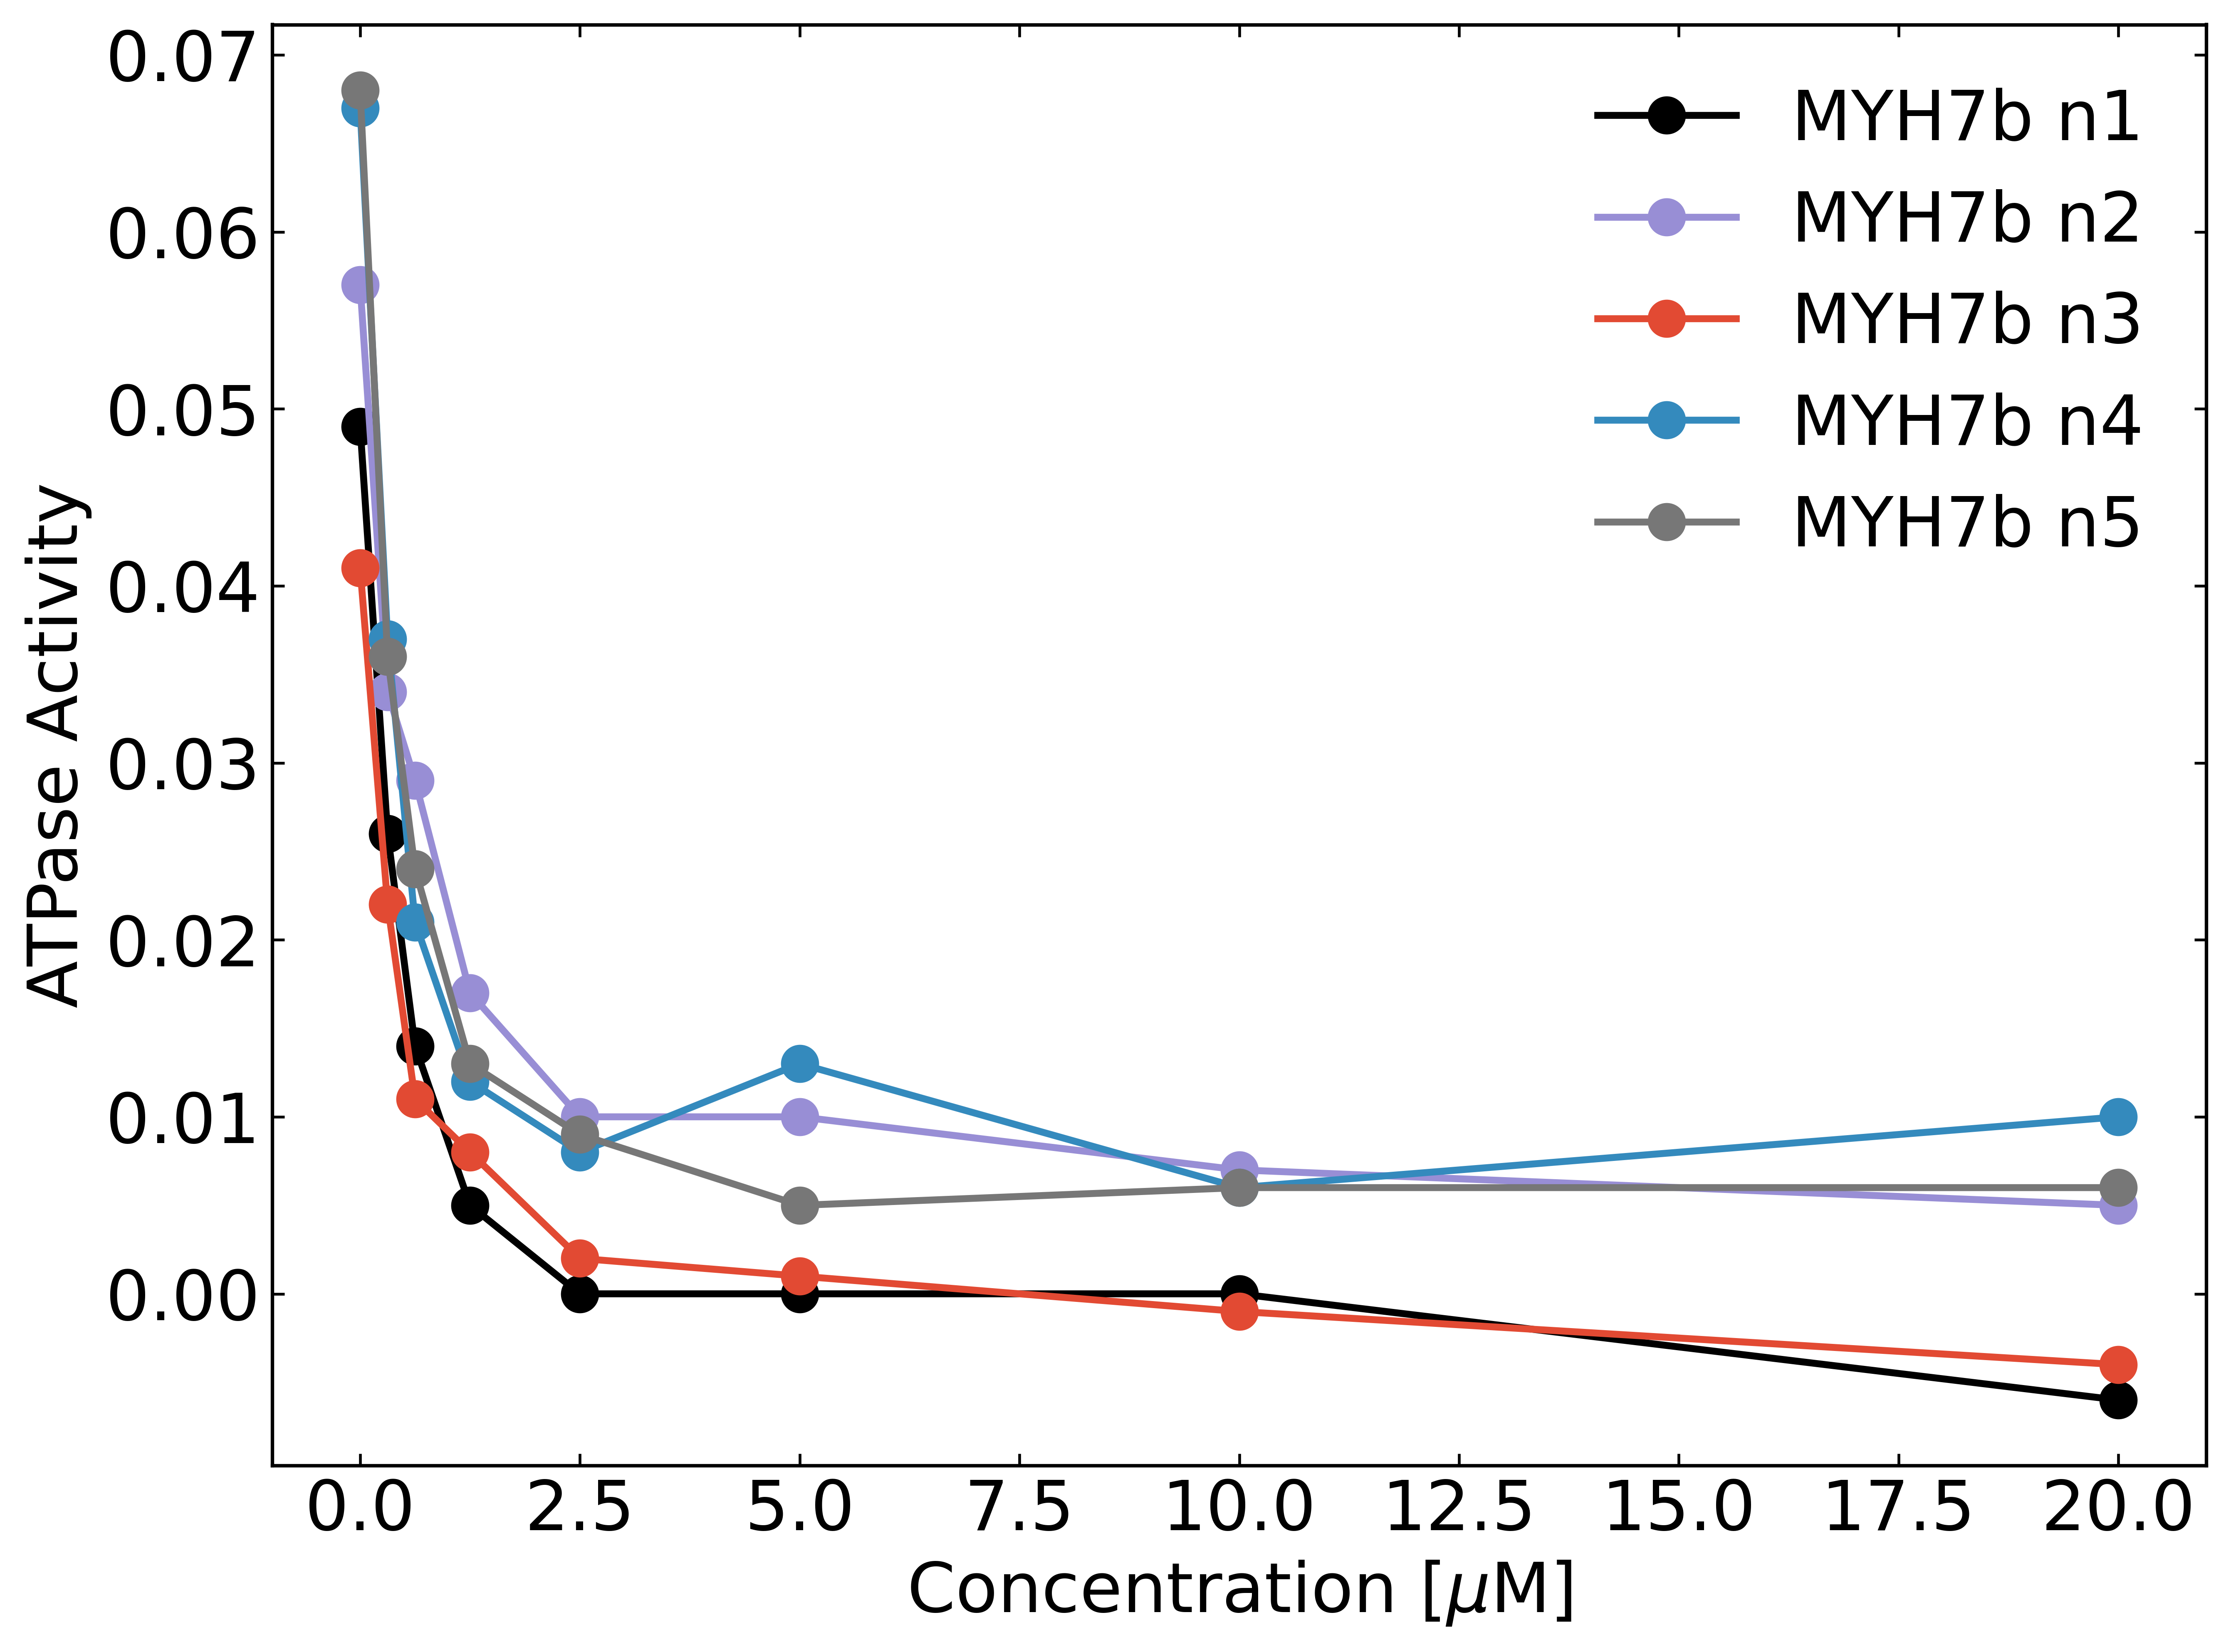

In [124]:
for i, df in enumerate(normalized_experiments):
    plt.plot(df['Concentration'].iloc[::-1],
             df['r_ATPase'].iloc[::-1],
             marker='o', label=f'MYH7b n{i+1}', markersize=10)
plt.xlabel('Concentration [$\mu$M]', fontsize=20)
plt.ylabel('ATPase Activity', fontsize=20)
plt.legend()
plt.savefig('../experimental-data/myh7b-raw-atpase-traces.png', dpi=300)
plt.show()

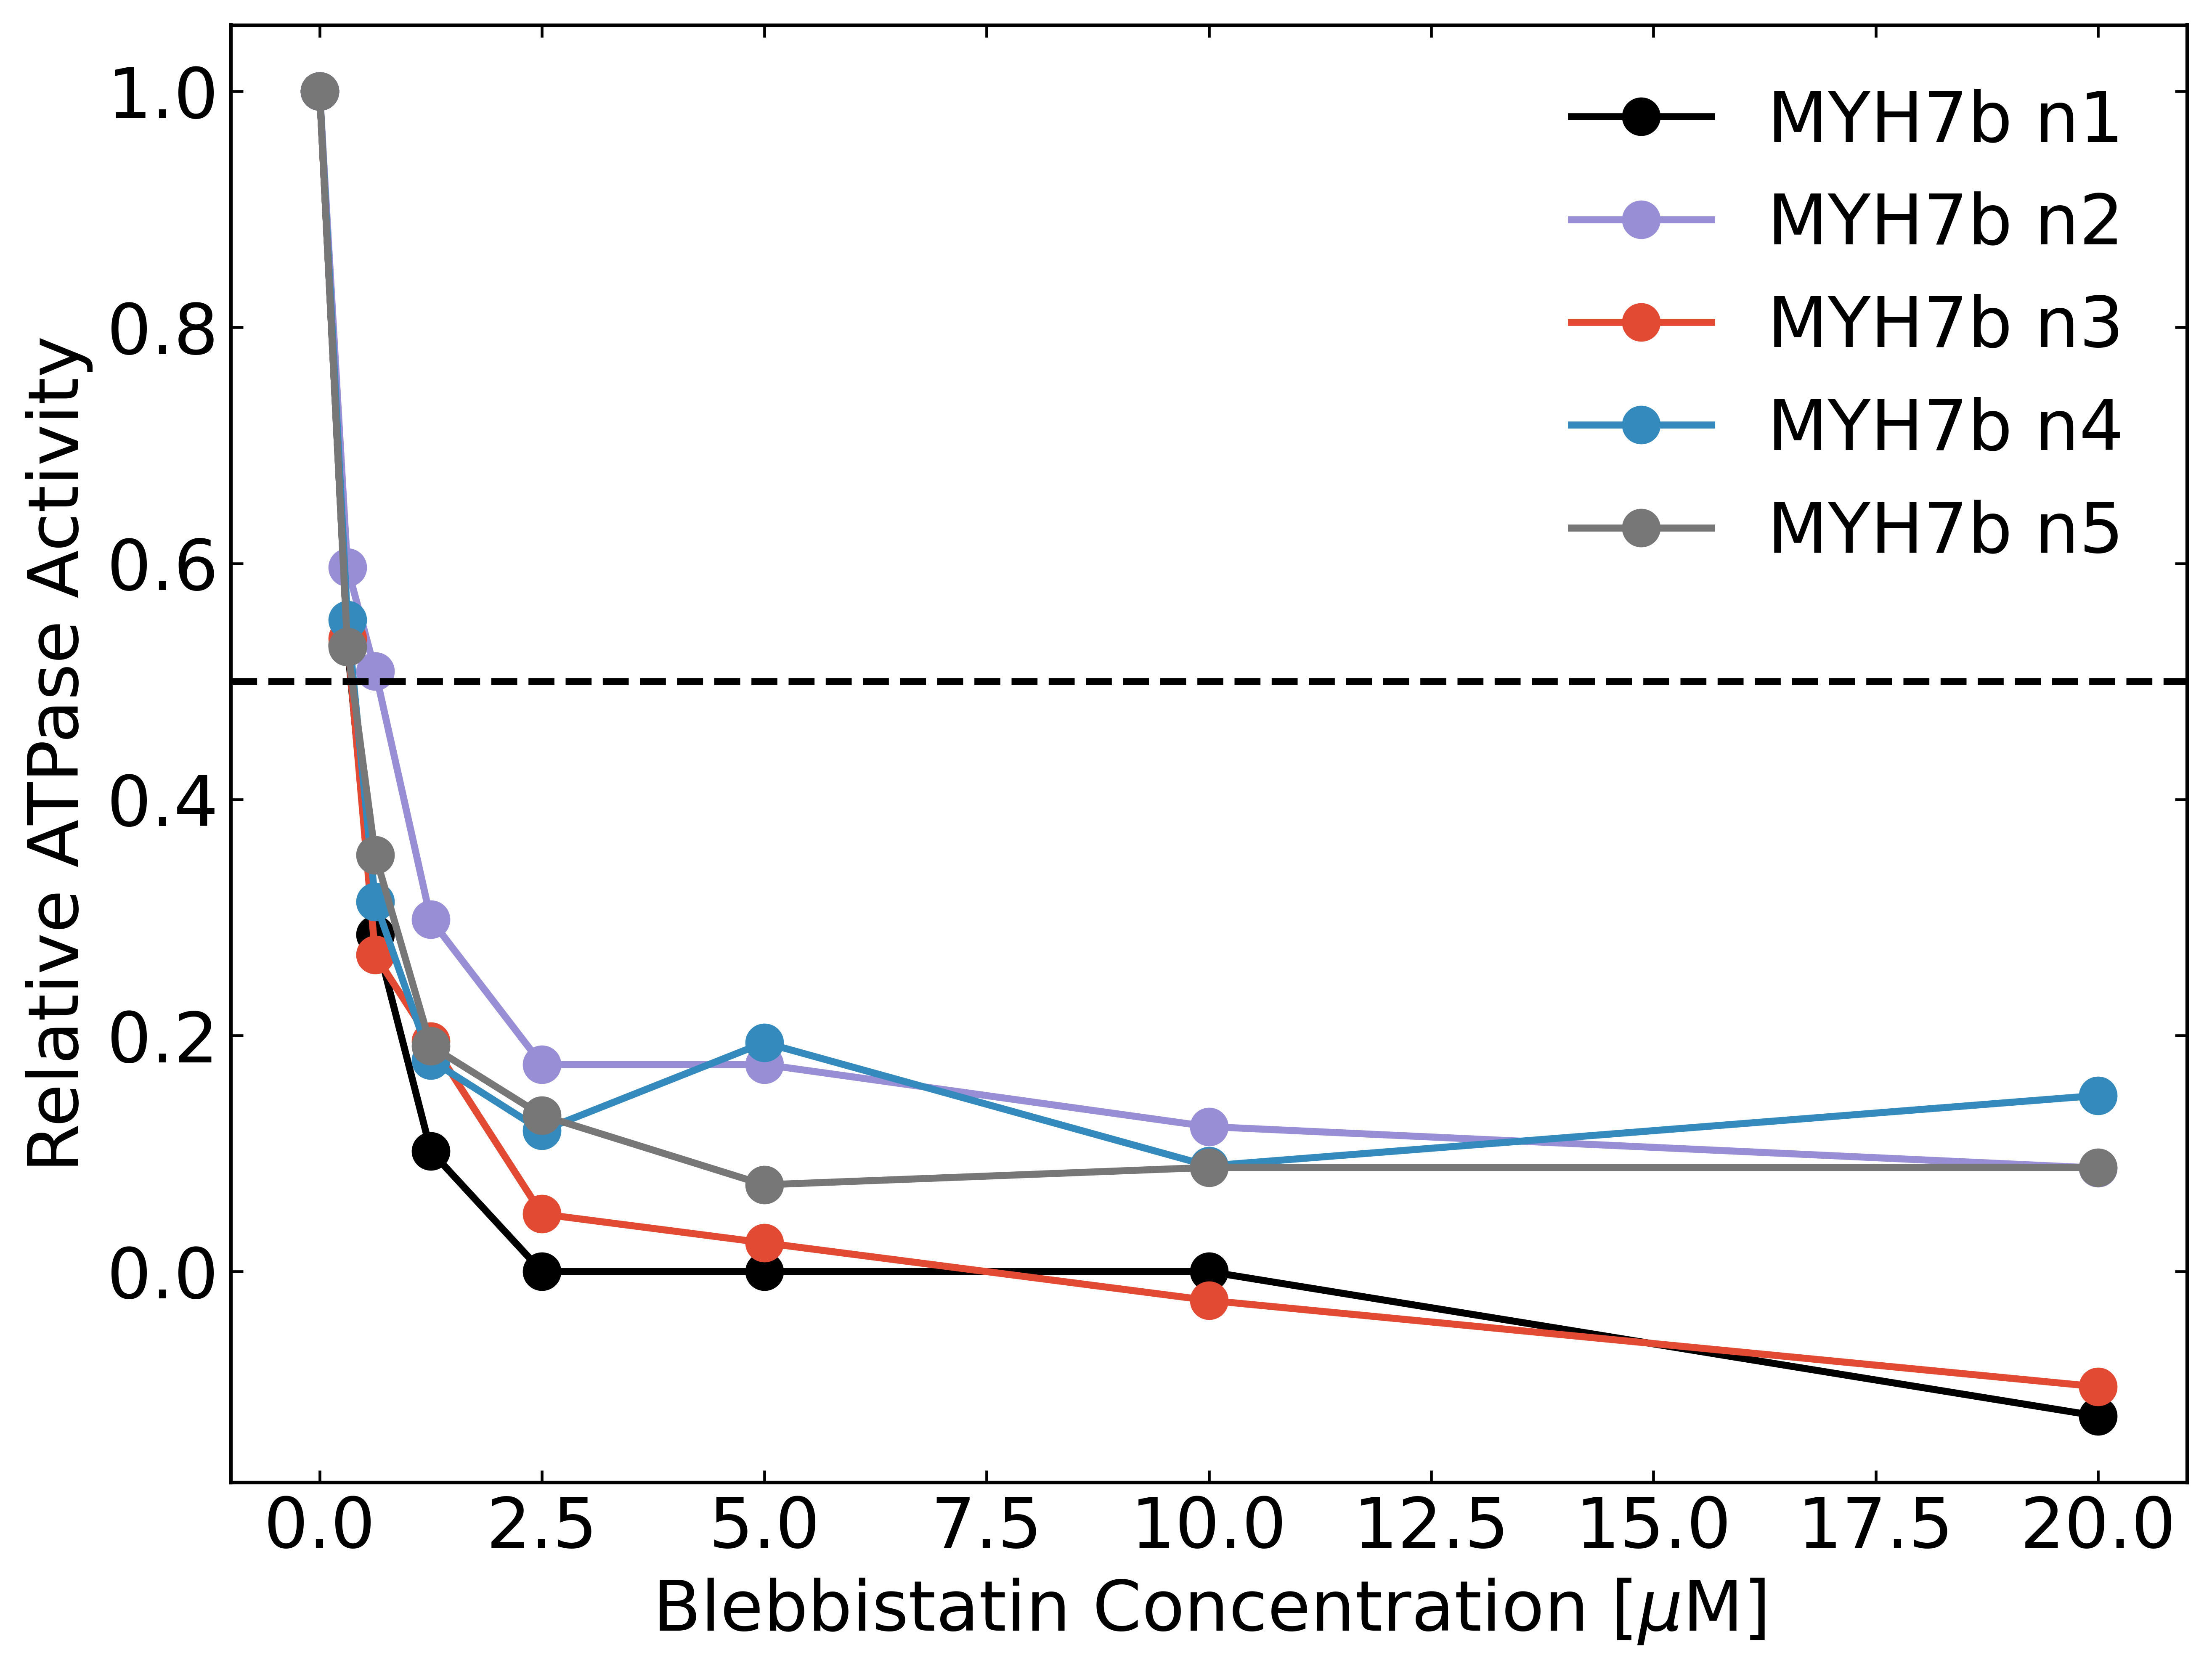

In [125]:
for i, df in enumerate(normalized_experiments):
    plt.plot(df['Concentration'].iloc[::-1],
             df['n_ATPase'].iloc[::-1],
             marker='o', label=f'MYH7b n{i+1}', markersize=10)
plt.xlabel('Blebbistatin Concentration [$\mu$M]', fontsize=20)
plt.ylabel('Relative ATPase Activity', fontsize=20)
plt.legend()
# plt.ylim((-0.1, 1.05))
# plt.xlim((0, 20))

plt.axhline(0.5, color='black', linestyle='--')

plt.savefig('../experimental-data/myh7b-percent-maximal-atpase.png', dpi=300)
plt.show()

## Fit with normalized activity, n as parameter

In [126]:
myh7b_IC50s = []
Ns = []

for i, df in enumerate(normalized_experiments):
    p0 = [1, 1]
    bounds = ((0, 0), (np.inf, np.inf))
    
    popt, pocv = curve_fit(ic50_equation_relative_activity,
                           df['Concentration'],
                           df['n_ATPase'],
                           p0=p0, bounds=bounds)
    print(f'Fitted values for trial {i}:')
    print(f'IC50: {popt[0]:.2f}')
    print(f'n: {popt[1]:.2f}')
    print('------------')
    myh7b_IC50s.append(popt[0])
    Ns.append(popt[1])

Fitted values for trial 0:
IC50: 0.34
n: 1.71
------------
Fitted values for trial 1:
IC50: 0.52
n: 0.77
------------
Fitted values for trial 2:
IC50: 0.34
n: 1.38
------------
Fitted values for trial 3:
IC50: 0.27
n: 0.69
------------
Fitted values for trial 4:
IC50: 0.32
n: 0.89
------------


In [135]:
print(f'IC50 fits: {np.mean(myh7b_IC50s) : .2f} +- {np.std(myh7b_IC50s) : .2f}')

IC50 fits:  0.36 +-  0.08


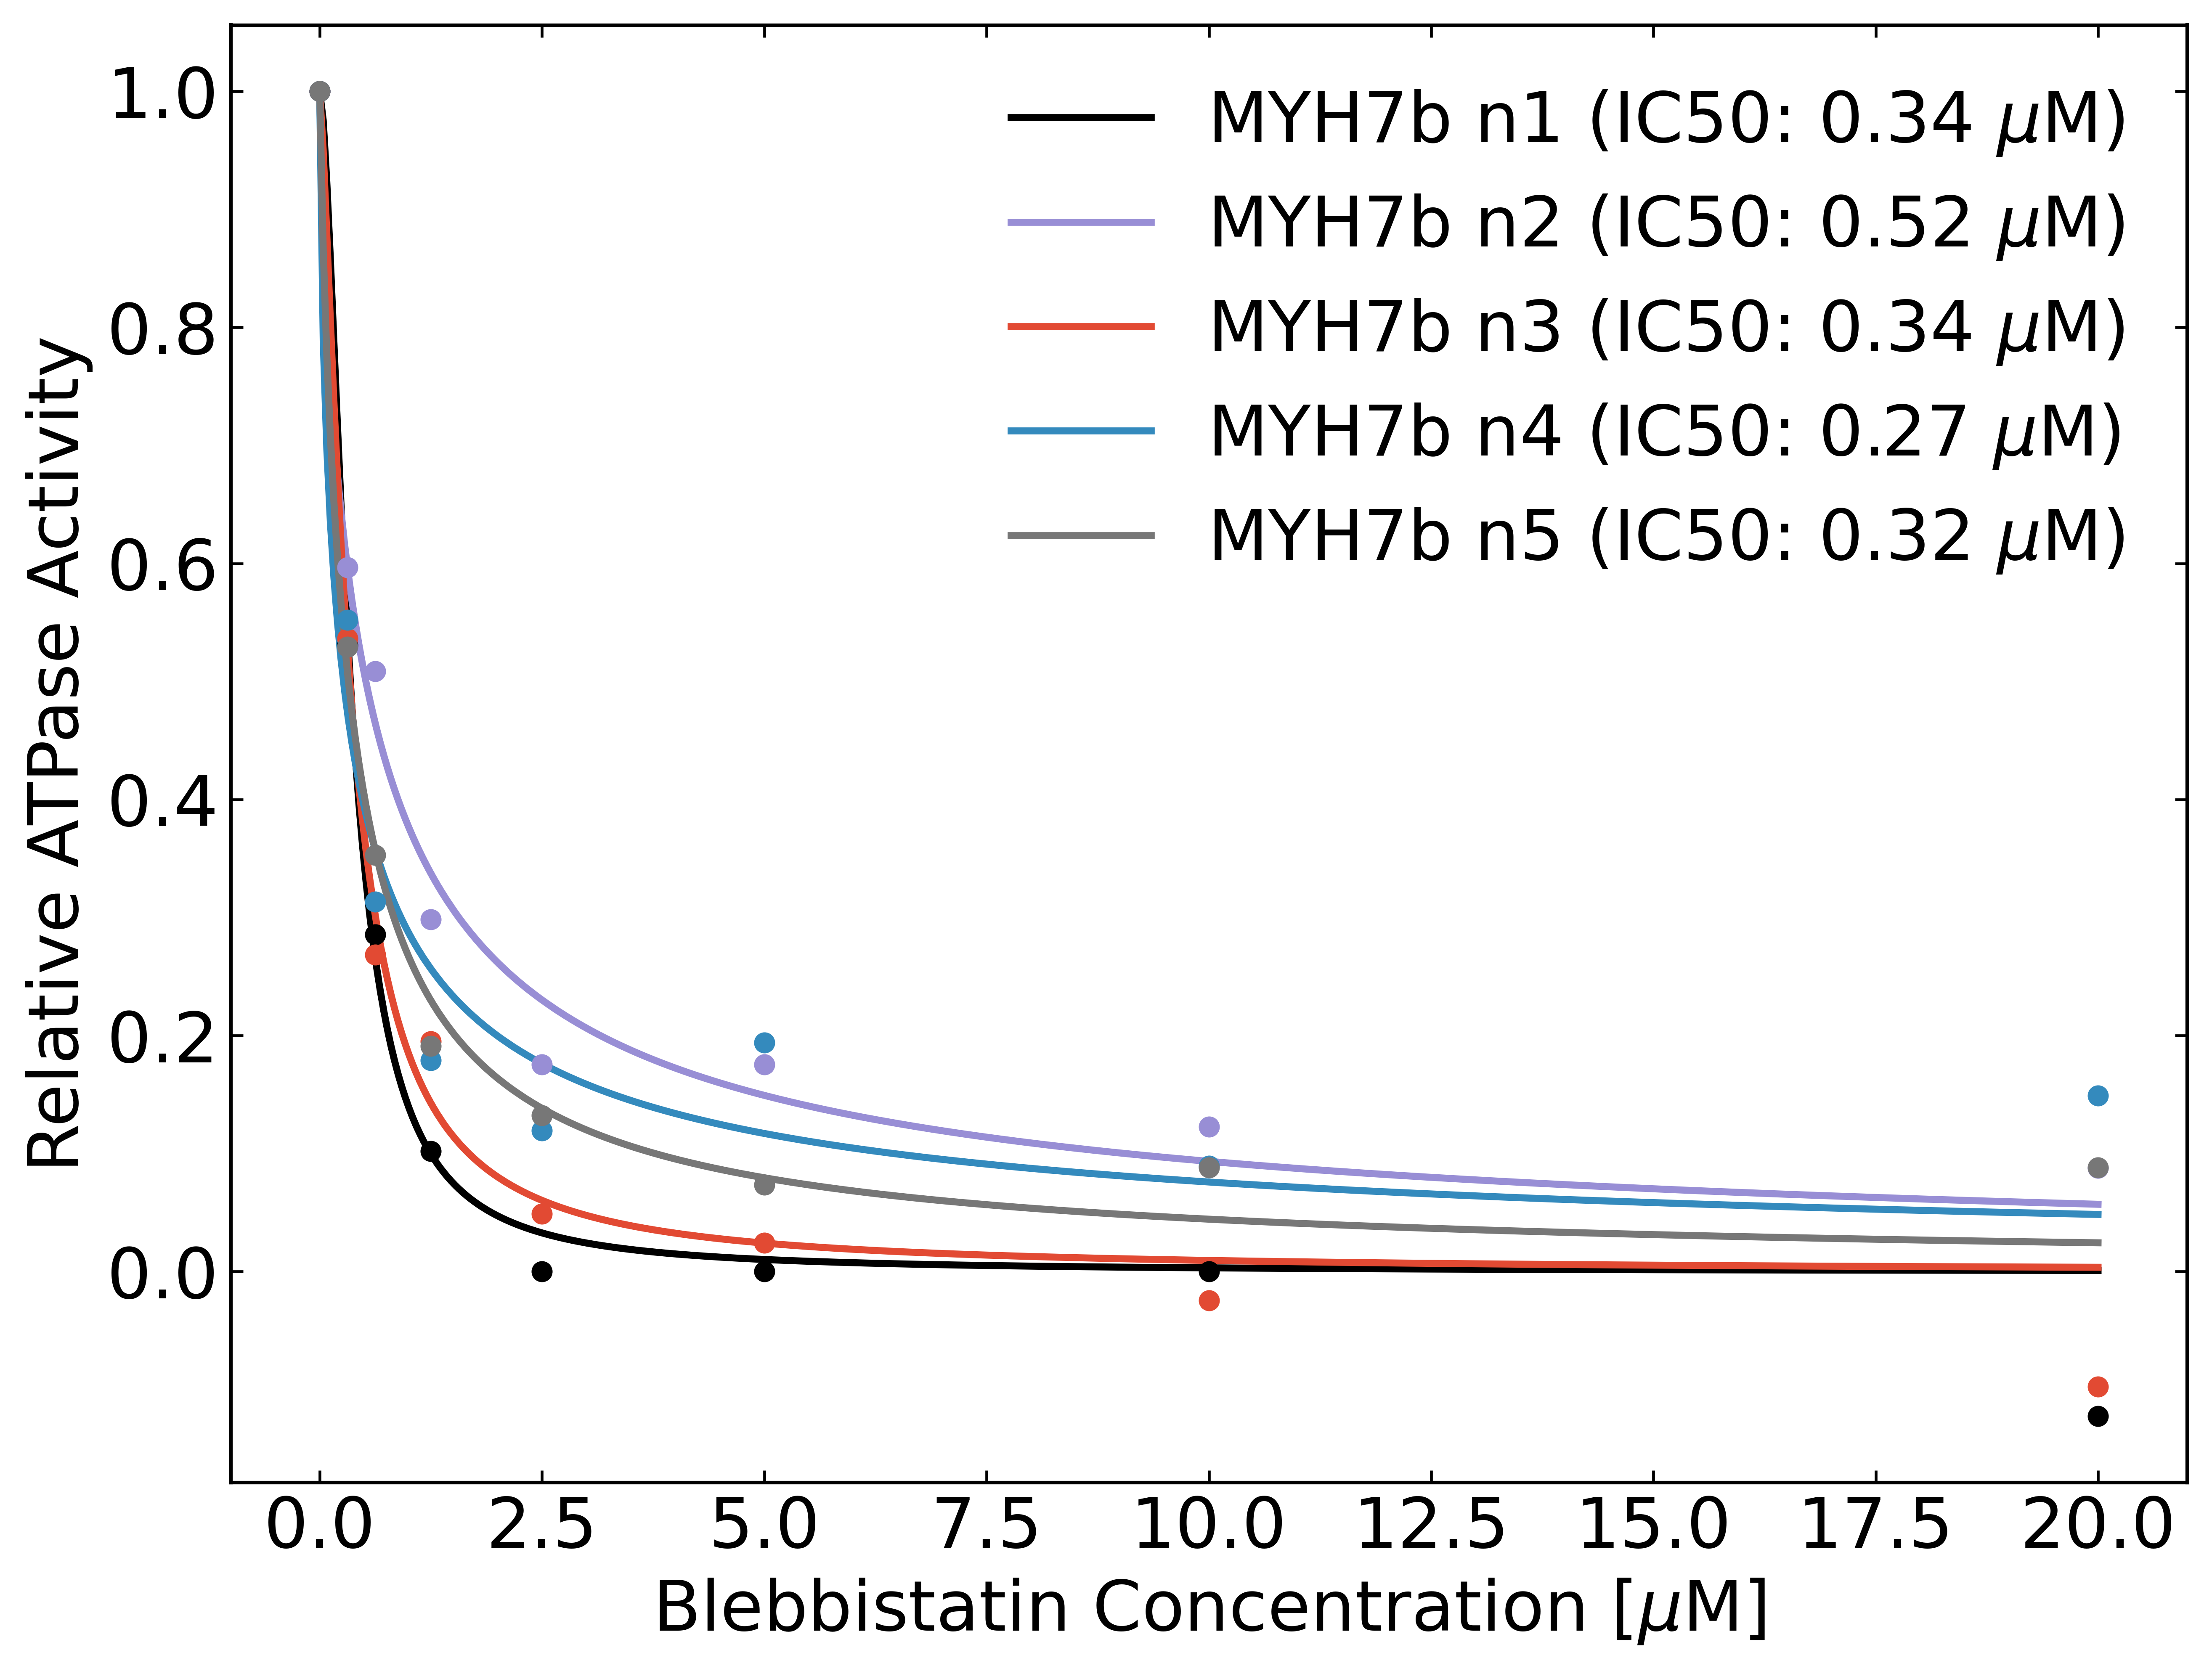

In [137]:
# Plot each curve individually
for i, df in enumerate(normalized_experiments):
    p = plt.errorbar(df['Concentration'].iloc[::-1],
                     df['n_ATPase'].iloc[::-1],
                     fmt='o', markersize=5)
    
    x_concentrations = np.linspace(0, 20, 500)
    plt.plot(x_concentrations,
             ic50_equation_relative_activity(x_concentrations, myh7b_IC50s[i], Ns[i]),
             label=f'MYH7b n{i+1} (IC50: {myh7b_IC50s[i]:.2f} $\mu$M)', color=p[0].get_color())
    
    
plt.legend()
# plt.xscale('log')
plt.xlabel('Blebbistatin Concentration [$\mu$M]')
plt.ylabel('Relative ATPase Activity')

plt.savefig('../experimental-data/myh7b-percent-maximal-atpase-all-curves.png', dpi=300)

plt.show()


In [132]:
# Merge experiments into single dataframe
combined_experiments = pd.merge(normalized_experiments[0].loc[:, ['Concentration', 'n_ATPase']],
                                normalized_experiments[1].loc[:, ['Concentration', 'n_ATPase']],
                                on='Concentration', how='outer', suffixes=(None, '_1'))

for i in range(2, len(normalized_experiments)):
    combined_experiments = pd.merge(combined_experiments,
                                    normalized_experiments[i].loc[:, ['Concentration', 'n_ATPase']],
                                    on='Concentration', how='outer', suffixes=(None, f'_{i}'))

# combined_experiments = combined_experiments.rename(columns={'n_ATPase': 'n_ATPase_3'})
combined_experiments['mean_n_ATPase'] = combined_experiments.iloc[:, 1:].mean(axis=1)
combined_experiments['std_n_ATPase'] = combined_experiments.iloc[:, 1:len(normalized_experiments)+1].std(axis=1)
combined_experiments

Concentration  n_ATPase  n_ATPase_1  n_ATPase_2  n_ATPase_3  n_ATPase_4  \
0        20.0000 -0.122449    0.087719   -0.097561    0.149254    0.088235   
1        10.0000  0.000000    0.122807   -0.024390    0.089552    0.088235   
2         5.0000  0.000000    0.175439    0.024390    0.194030    0.073529   
3         2.5000  0.000000    0.175439    0.048780    0.119403    0.132353   
4         1.2500  0.102041    0.298246    0.195122    0.179104    0.191176   
5         0.6250  0.285714    0.508772    0.268293    0.313433    0.352941   
6         0.3125  0.530612    0.596491    0.536585    0.552239    0.529412   
7         0.0000  1.000000    1.000000    1.000000    1.000000    1.000000   

   mean_n_ATPase  std_n_ATPase  
0       0.021040      0.122531  
1       0.055241      0.063686  
2       0.093478      0.087660  
3       0.095195      0.070040  
4       0.193138      0.069913  
5       0.345831      0.096535  
6       0.549068      0.028026  
7       1.000000      0.000000

In [131]:
p0 = [1, 1]
bounds = ((0, 0), (np.inf, np.inf))

popt, pcov = curve_fit(ic50_equation_relative_activity,
                       combined_experiments['Concentration'],
                       combined_experiments['mean_n_ATPase'],
                       p0=p0, bounds=bounds)

overall_IC50 = popt[0]
overall_n = popt[1]

print(overall_IC50, overall_n)

perr = np.sqrt(np.diag(pcov))
print(perr)

0.35654848099787256 1.0635271354883942
[0.02359618 0.07716264]


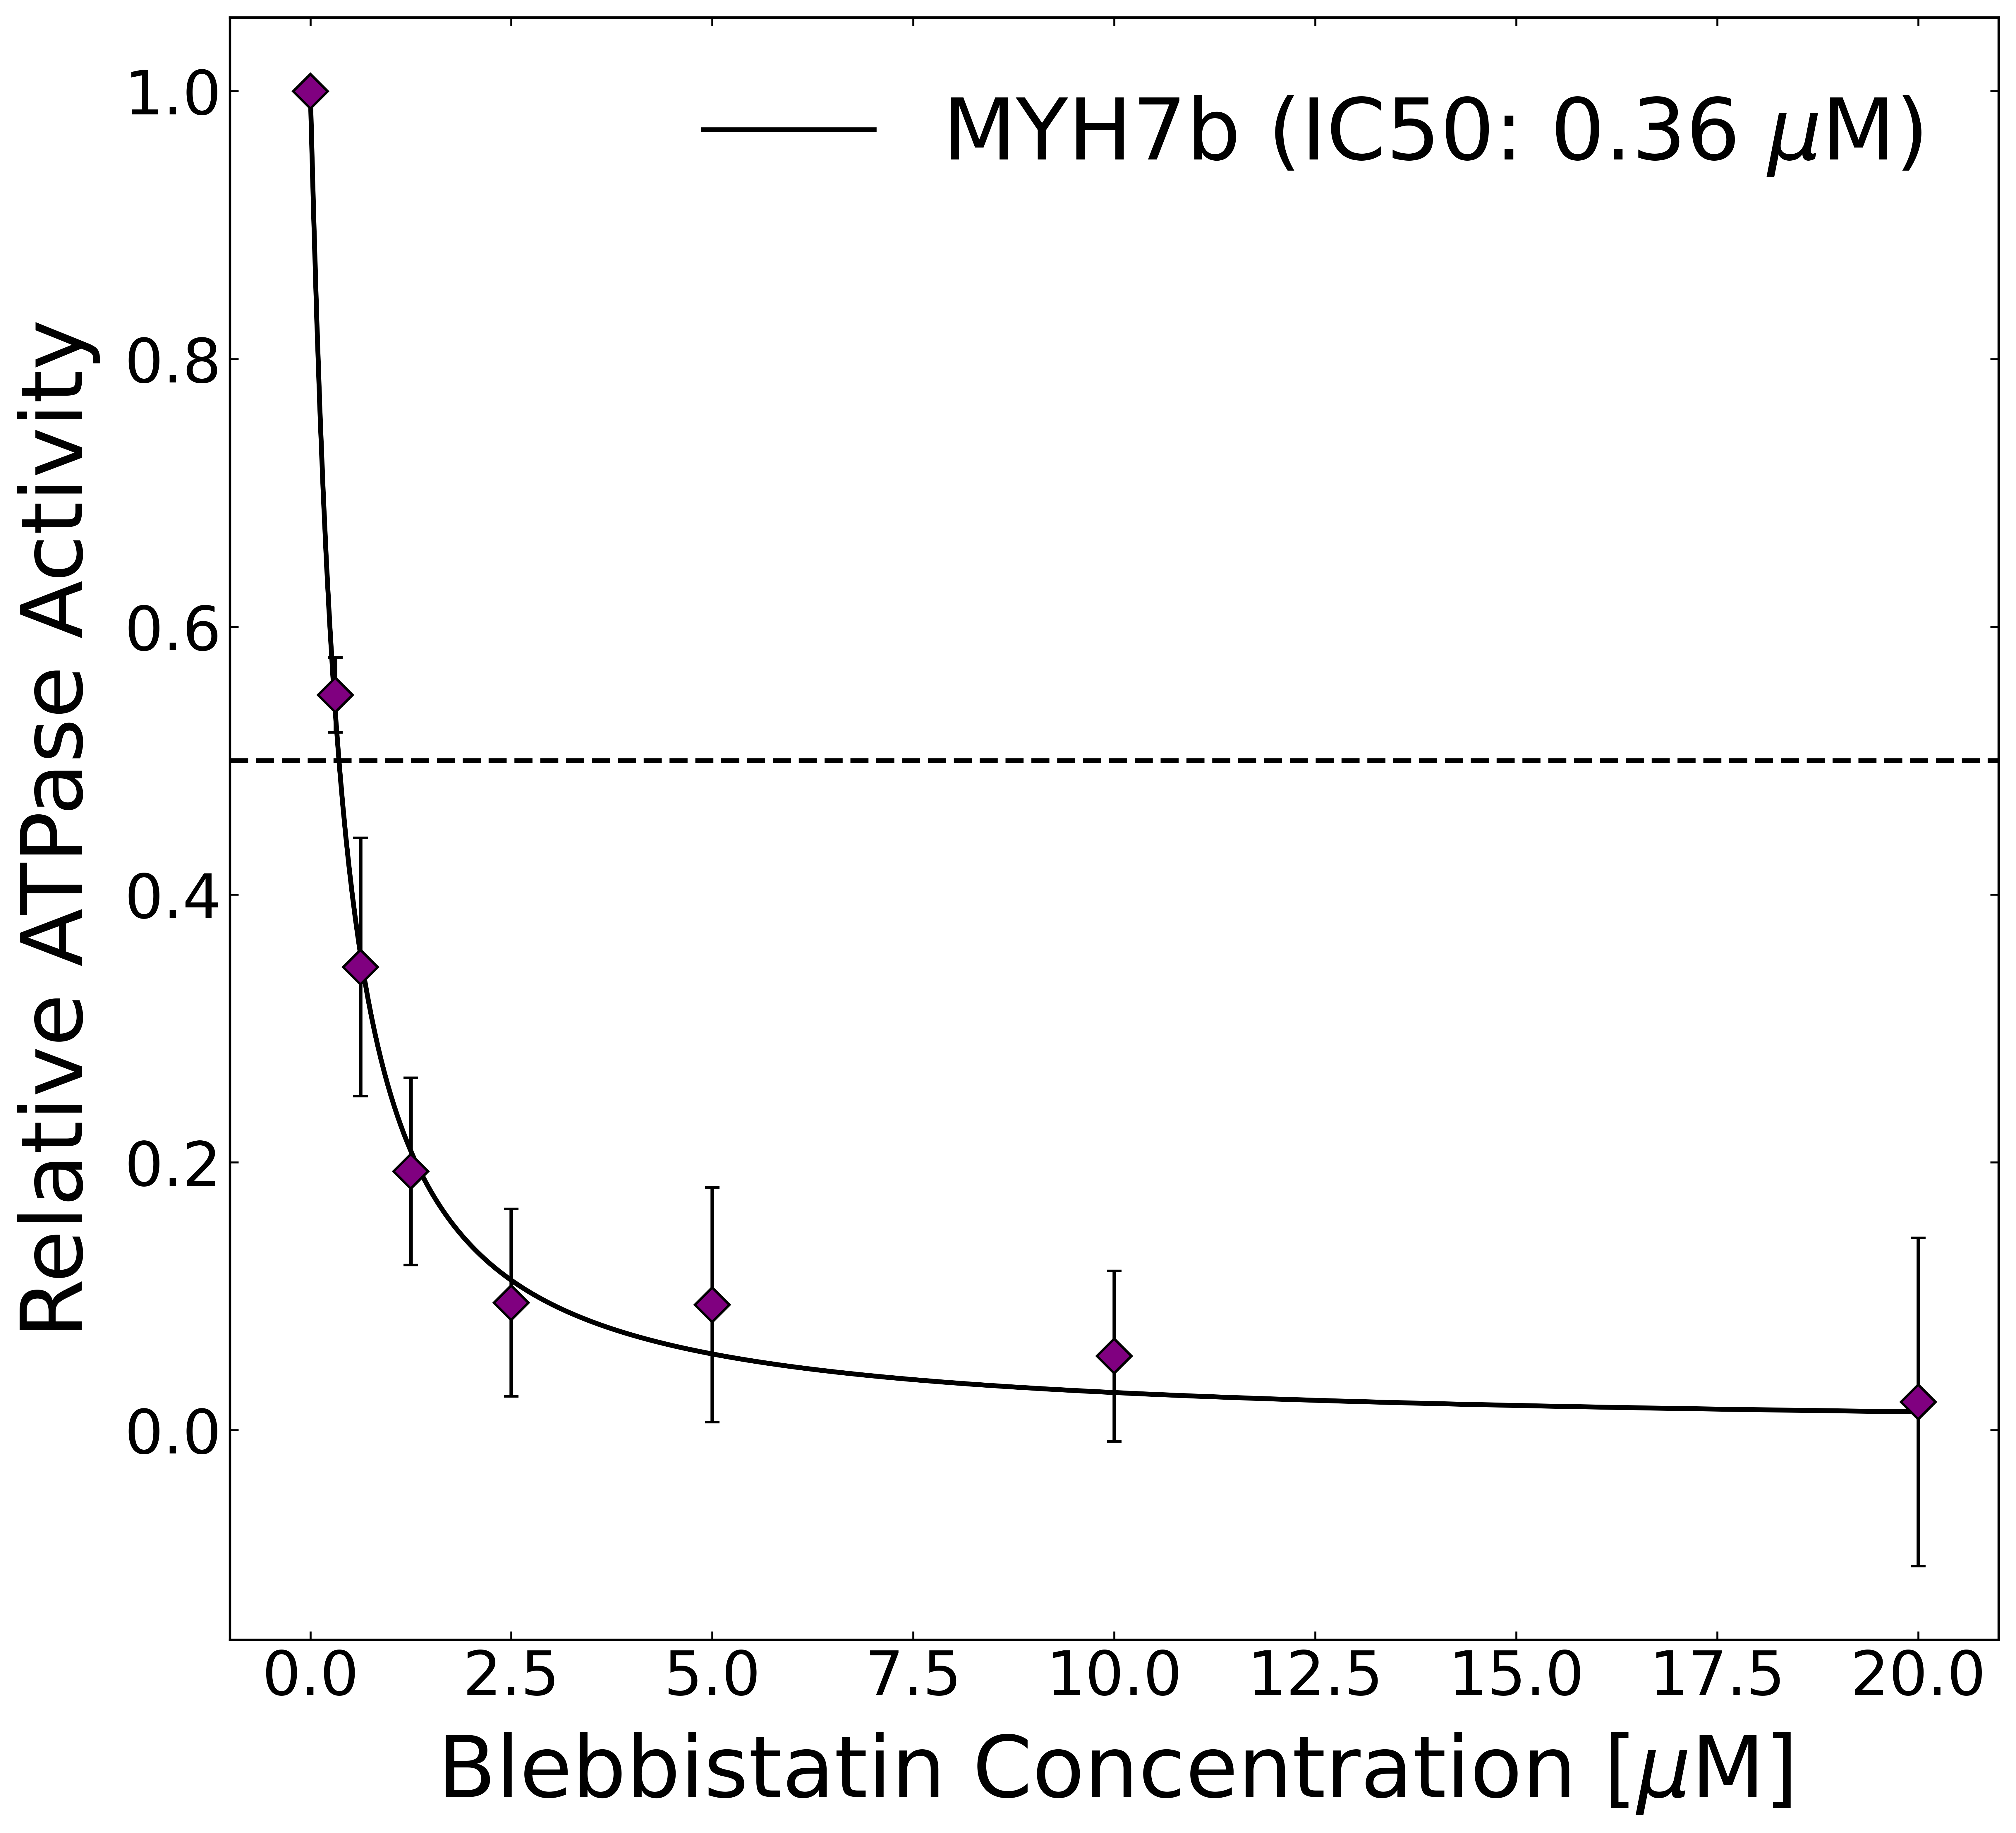

In [140]:
fig,ax = plt.subplots(1, 1, figsize=(13,12))

ax.errorbar(combined_experiments['Concentration'],
            combined_experiments['mean_n_ATPase'],
            combined_experiments['std_n_ATPase'], fmt='D', markersize=10,
            color='purple', ecolor = 'k', 
            elinewidth = 1.5, capsize = 3, markeredgecolor = 'k')

x_concentrations = np.linspace(0, 20, 500)
ax.plot(x_concentrations,
         ic50_equation_relative_activity(x_concentrations, overall_IC50, overall_n),
         label=f'MYH7b (IC50: {overall_IC50:.2f} $\mu$M)')

ax.set_xlabel('Blebbistatin Concentration [$\mu$M]', fontsize=35, labelpad=10)
ax.set_ylabel('Relative ATPase Activity', fontsize=35, labelpad=10)

ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)

ax.legend(fontsize=35)

# plt.legend(fontsize=15)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.ylim((0, 1.05))
# plt.xlim((0, 100))

ax.axhline(0.5, color='black', linestyle='--')

plt.savefig('../experimental-data/myh7b-percent-maximal-atpase-combined-curve.png', dpi=300)
plt.savefig('../figures/specificity/final-submission/myh7b-percent-maximal-atpase-combined-curve.png',
            dpi=300)
plt.savefig('../figures/specificity/final-submission/myh7b-percent-maximal-atpase-combined-curve.pdf',
            dpi=300)
plt.show()

# Beta-cardiac

In [141]:
# Load in data
myh7_experiments = [
    pd.read_csv(f)
    for f in glob('/mnt/bowmore/bowmore/ameller/projects/experimental-data/beta_cardiac_actin_control_*.csv')
]

# experimental_data = pd.read_csv('/mnt/bowmore/bowmore/ameller/projects/experimental-data/'
#                                 'myh7b-bleb-inhibition-atpase.csv')
# experimental_data

In [142]:
normalized_experiments = []
for df in myh7_experiments:
    control_value = float(df.loc[df['Concentration'] == 'Control']['ATPase'])
    df2 = df.loc[df['Concentration'] != 'Control']
    df2['Concentration'] = pd.to_numeric(df2['Concentration'])
    df2['r_ATPase'] = df2['ATPase'] - control_value
    df2['n_ATPase'] = df2['r_ATPase'] / float(df2.loc[df2['Concentration'] == 0]['r_ATPase'])
    normalized_experiments.append(df2)

/home/artur/anaconda3/envs/enspara/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/artur/anaconda3/envs/enspara/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/artur/anaconda3/envs/enspara/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

In [143]:
normalized_experiments[1]

Concentration  ATPase  r_ATPase  n_ATPase
0          10.00   0.033      0.00  0.000000
1           1.25   0.063      0.03  0.230769
2           0.00   0.163      0.13  1.000000

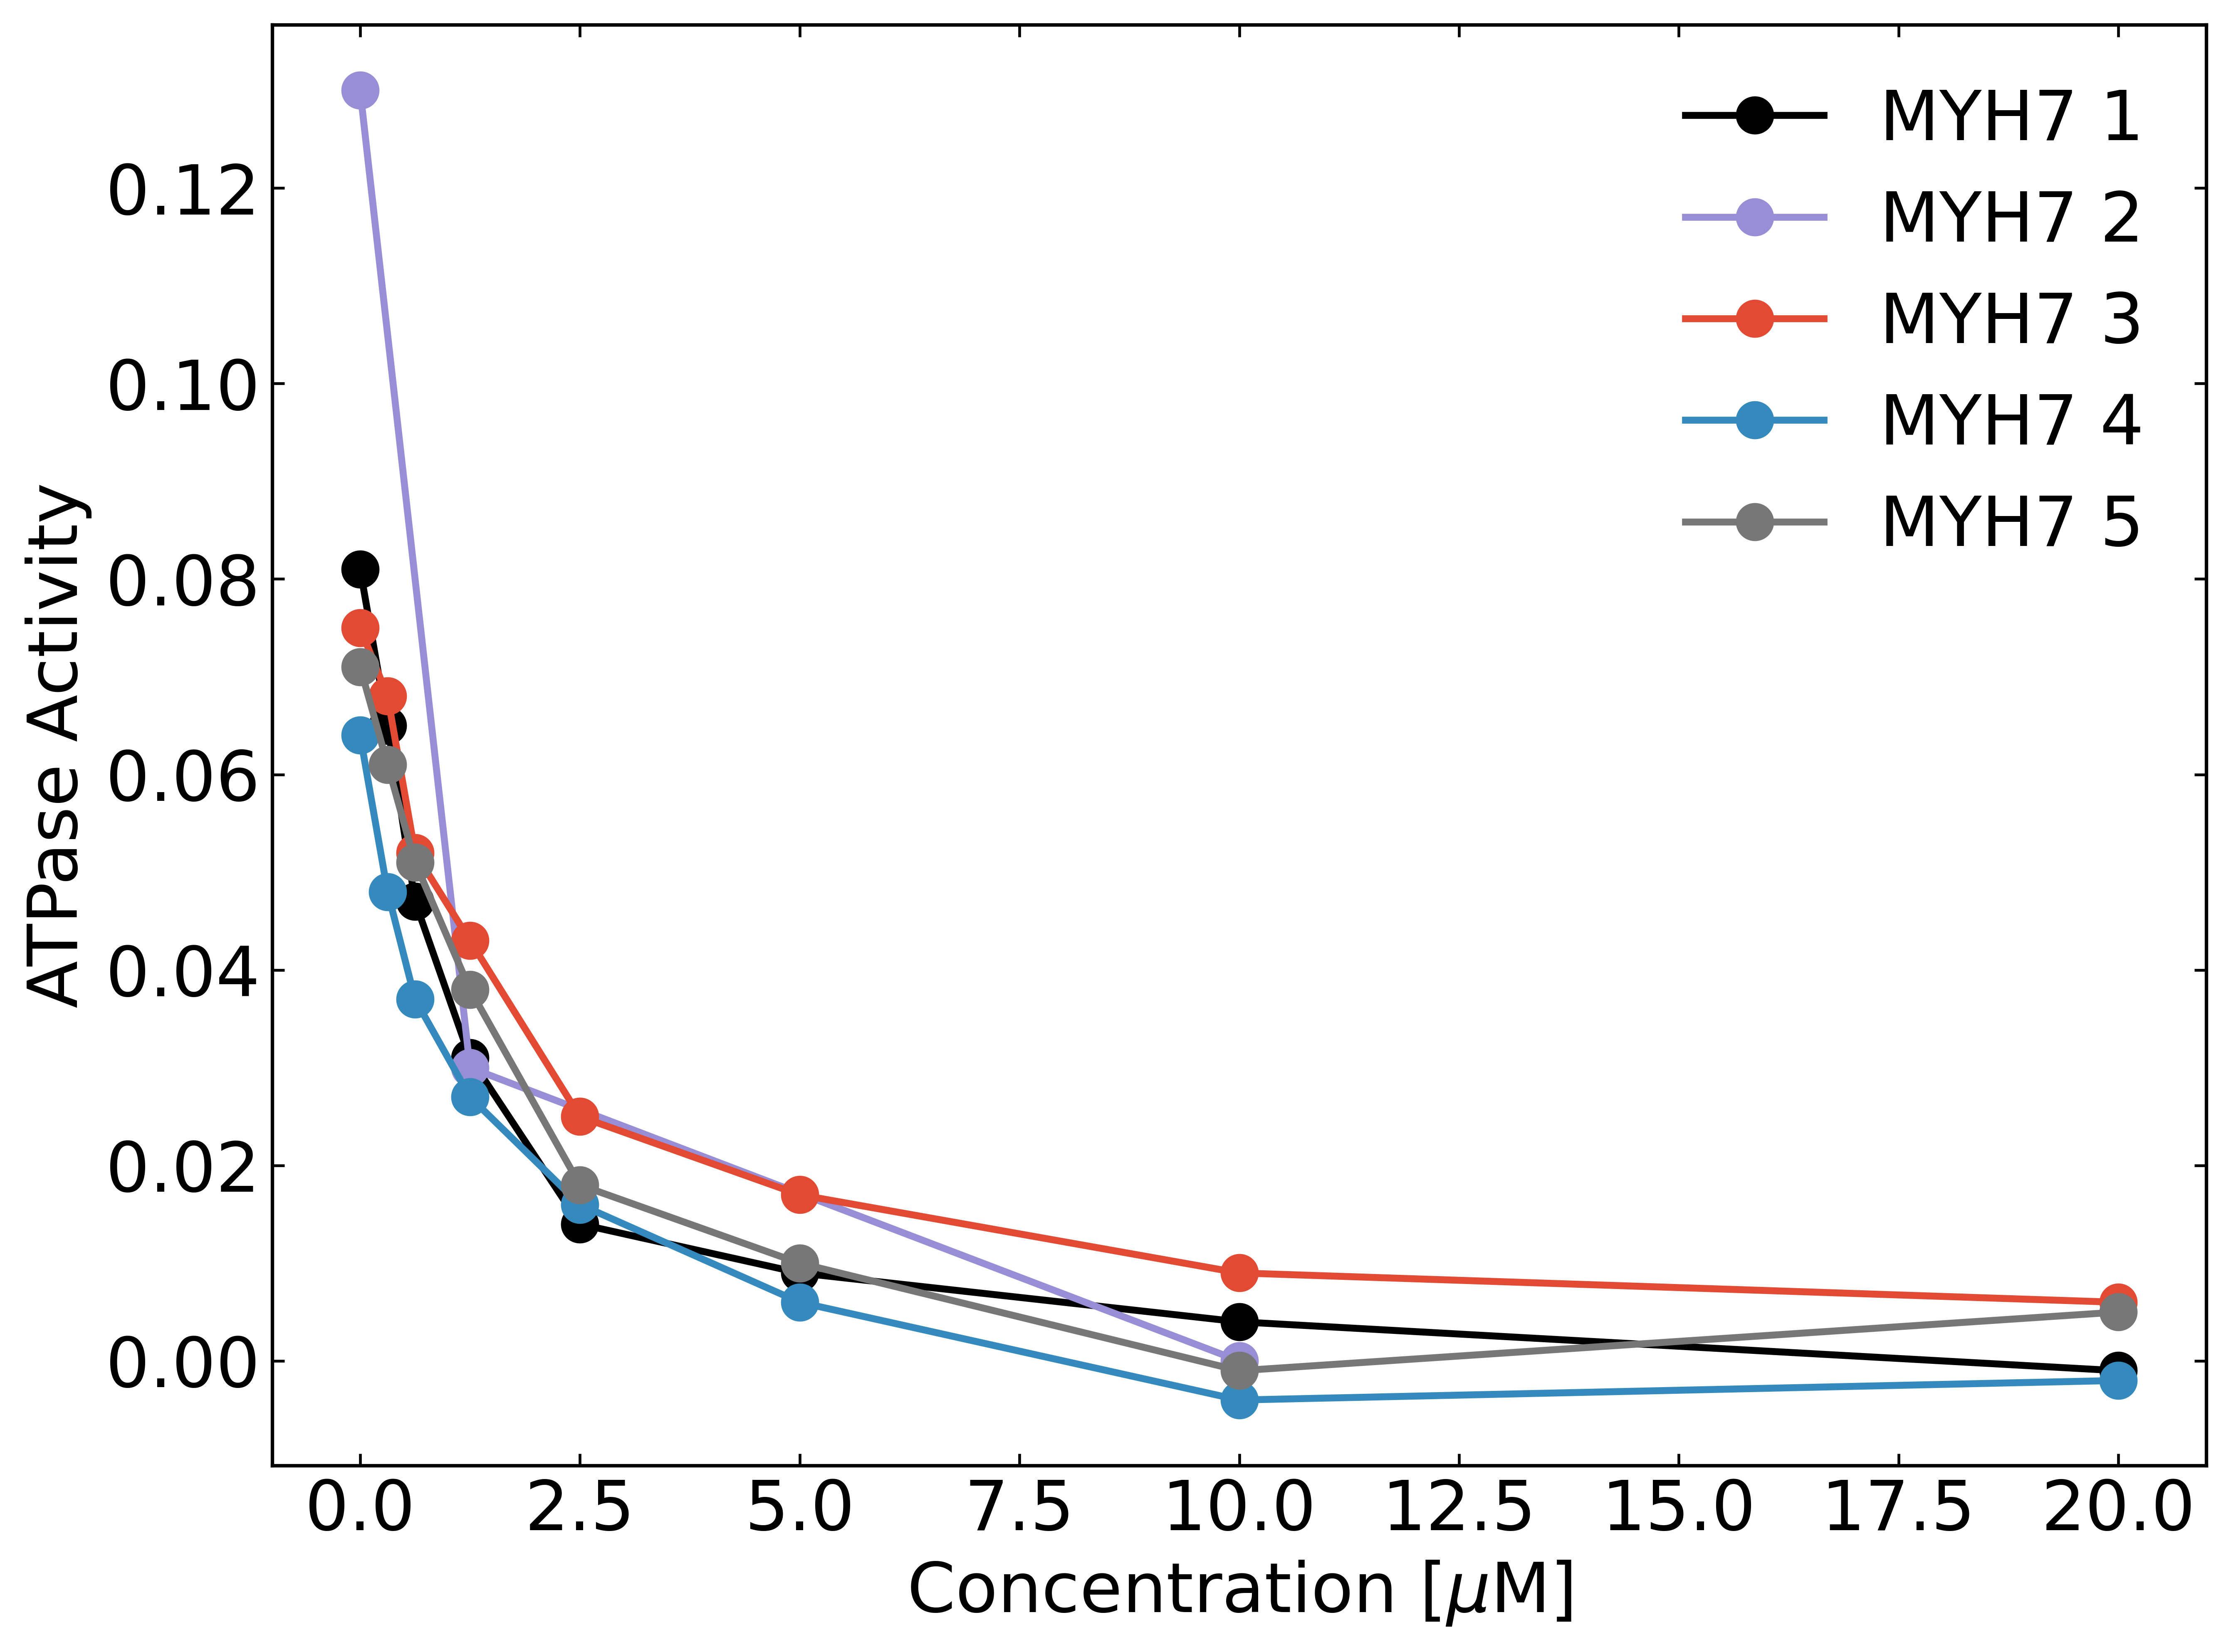

In [144]:
for i, df in enumerate(normalized_experiments):
    plt.plot(df['Concentration'].iloc[::-1],
             df['r_ATPase'].iloc[::-1],
             marker='o', label=f'MYH7 {i+1}', markersize=10)
plt.xlabel('Concentration [$\mu$M]', fontsize=20)
plt.ylabel('ATPase Activity', fontsize=20)
plt.legend()
plt.savefig('../experimental-data/myh7-raw-atpase-traces.png', dpi=300)
plt.show()

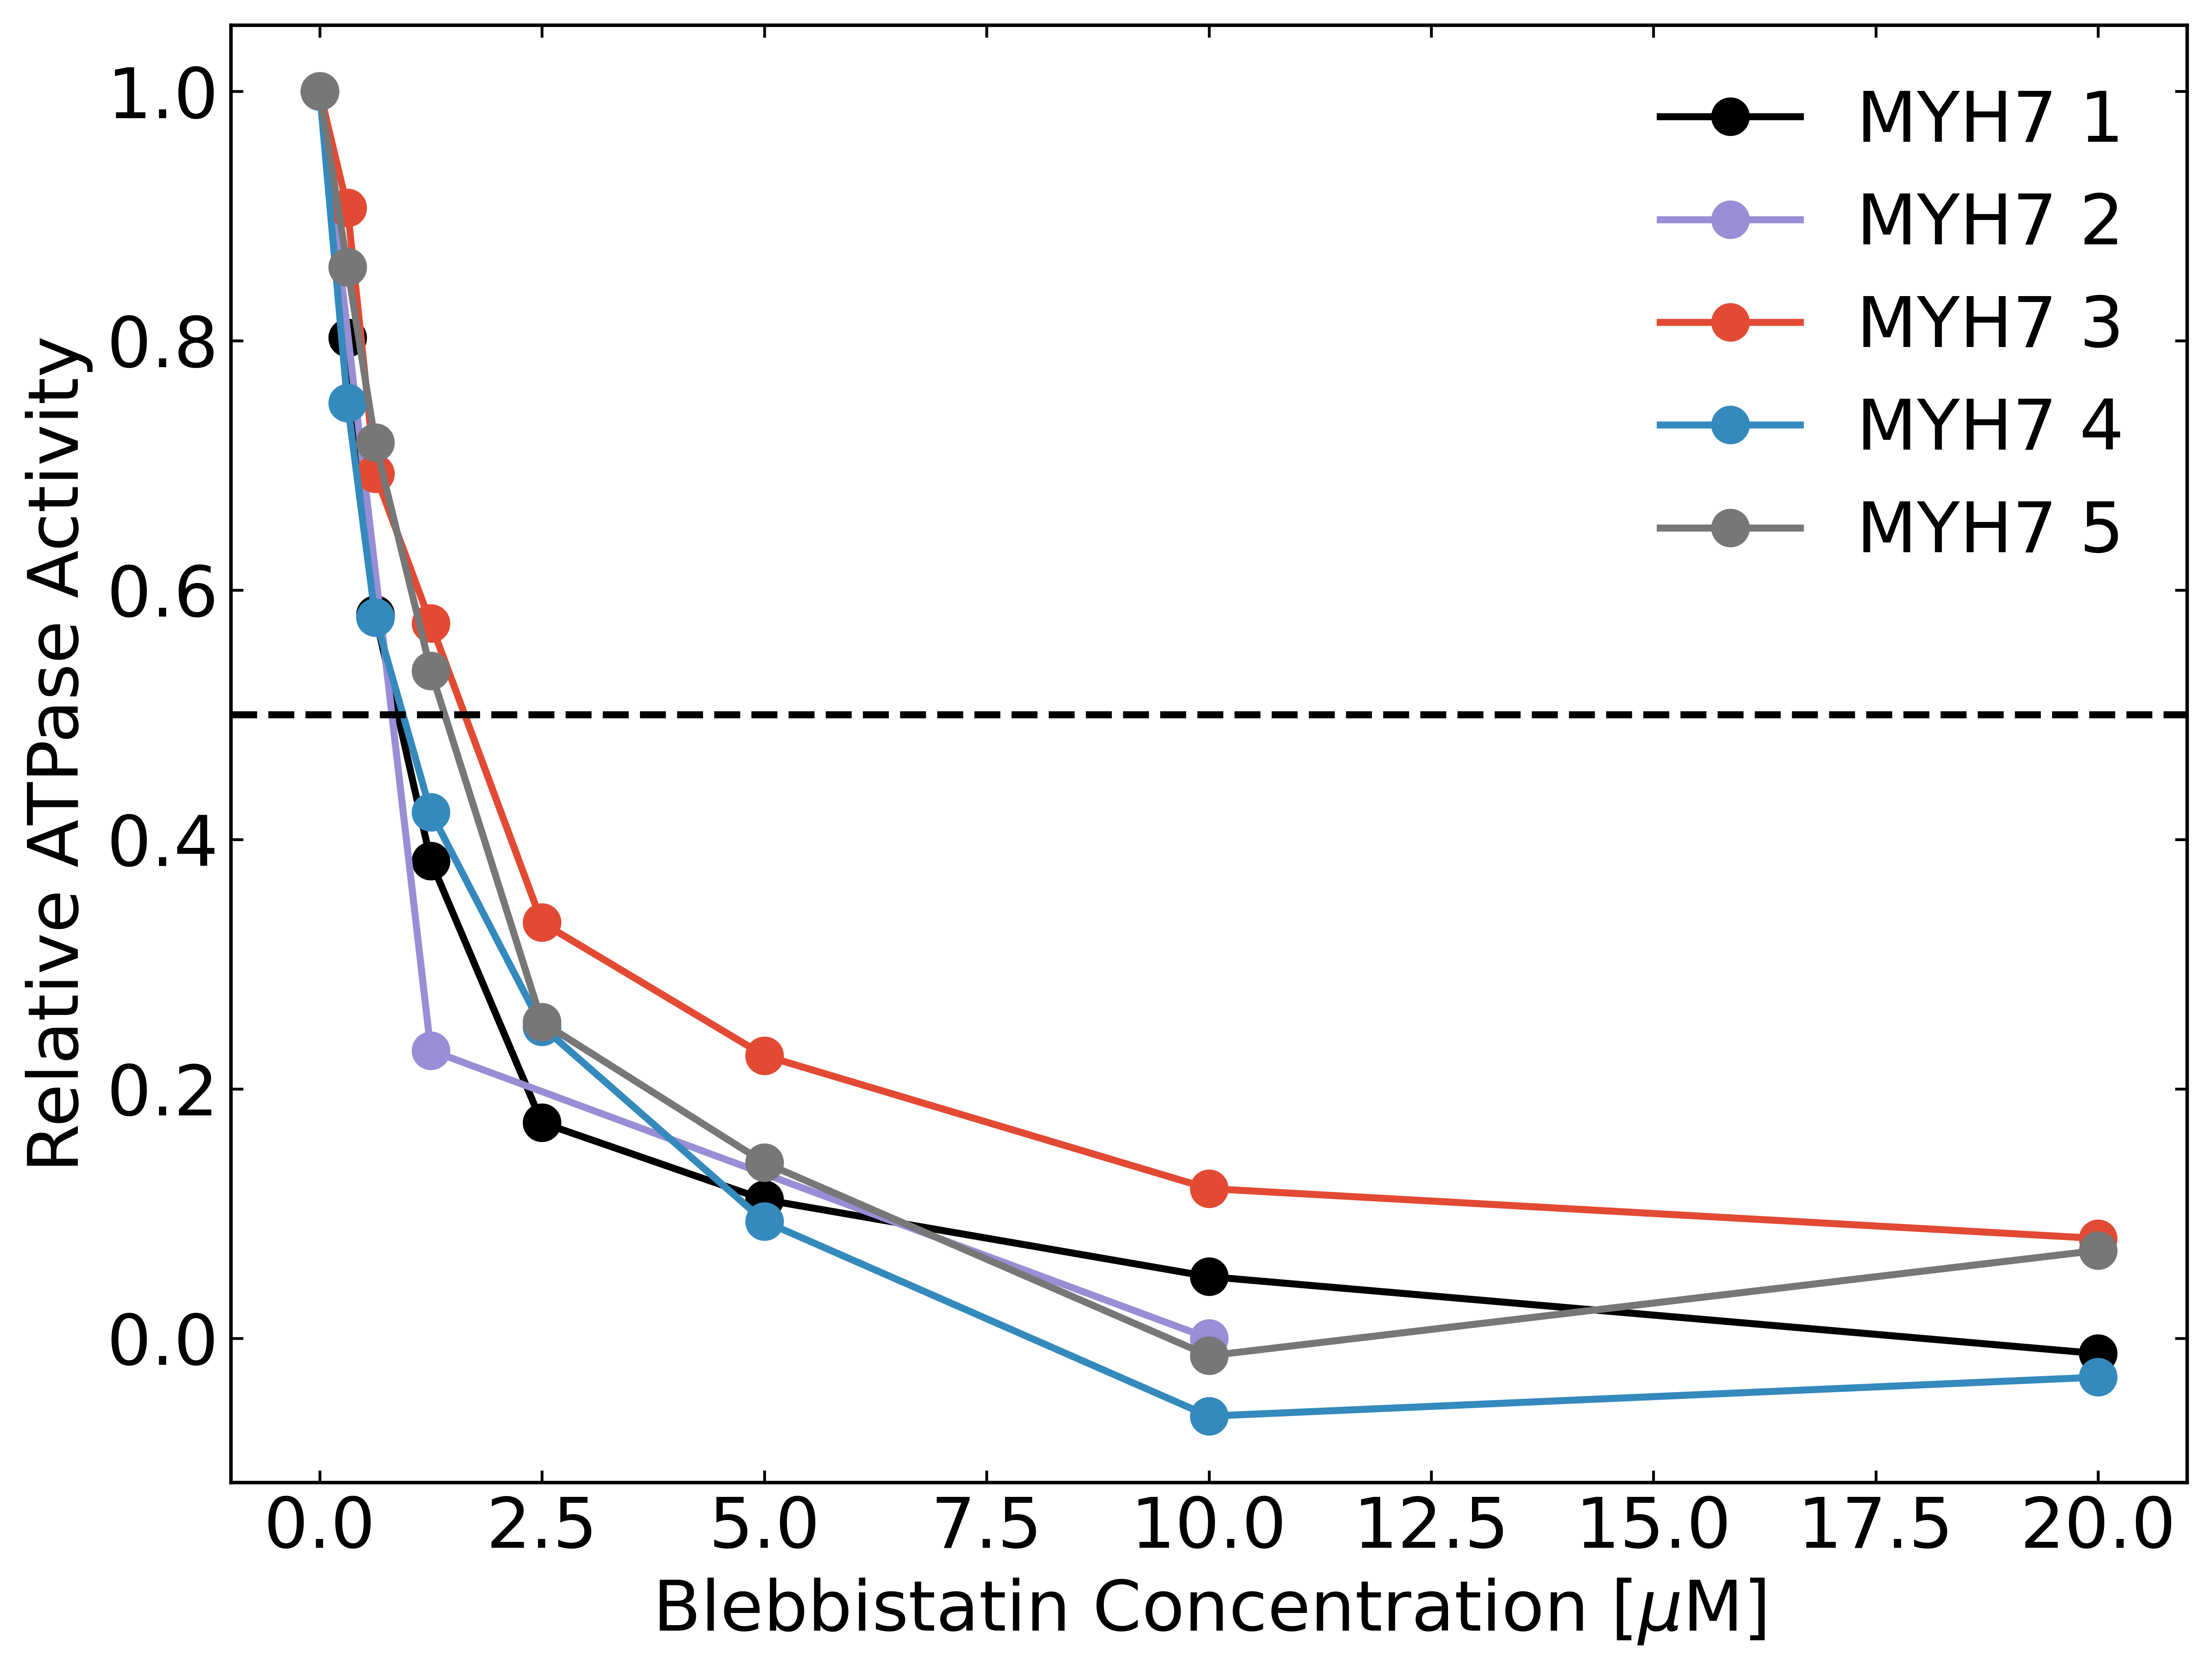

In [83]:
for i, df in enumerate(normalized_experiments):
    plt.plot(df['Concentration'].iloc[::-1],
             df['n_ATPase'].iloc[::-1],
             marker='o', label=f'MYH7 {i+1}', markersize=10)
plt.xlabel('Blebbistatin Concentration [$\mu$M]', fontsize=20)
plt.ylabel('Relative ATPase Activity', fontsize=20)
plt.legend()
# plt.ylim((-0.1, 1.05))
# plt.xlim((0, 20))

plt.axhline(0.5, color='black', linestyle='--')

plt.savefig('../experimental-data/myh7-percent-maximal-atpase.png', dpi=300)
plt.show()

## Fit with normalized activity, n as parameter

In [145]:
myh7_IC50s = []
Ns = []

for i, df in enumerate(normalized_experiments):
    if i == 1:
        continue
    
    p0 = [1, 1]
    bounds = ((0, 0), (np.inf, np.inf))
    
    popt, pocv = curve_fit(ic50_equation_relative_activity,
                           df['Concentration'],
                           df['n_ATPase'],
                           p0=p0, bounds=bounds)
    print(f'Fitted values for trial {i}:')
    print(f'IC50: {popt[0]:.2f}')
    print(f'n: {popt[1]:.2f}')
    print('------------')
    myh7_IC50s.append(popt[0])
    Ns.append(popt[1])

Fitted values for trial 0:
IC50: 0.84
n: 1.32
------------
Fitted values for trial 2:
IC50: 1.53
n: 1.11
------------
Fitted values for trial 3:
IC50: 0.86
n: 1.23
------------
Fitted values for trial 4:
IC50: 1.26
n: 1.41
------------


In [147]:
print(f'IC50 fits: {np.mean(myh7_IC50s) : .2f} +- {np.std(myh7_IC50s) : .2f}')

IC50 fits:  1.12 +-  0.29


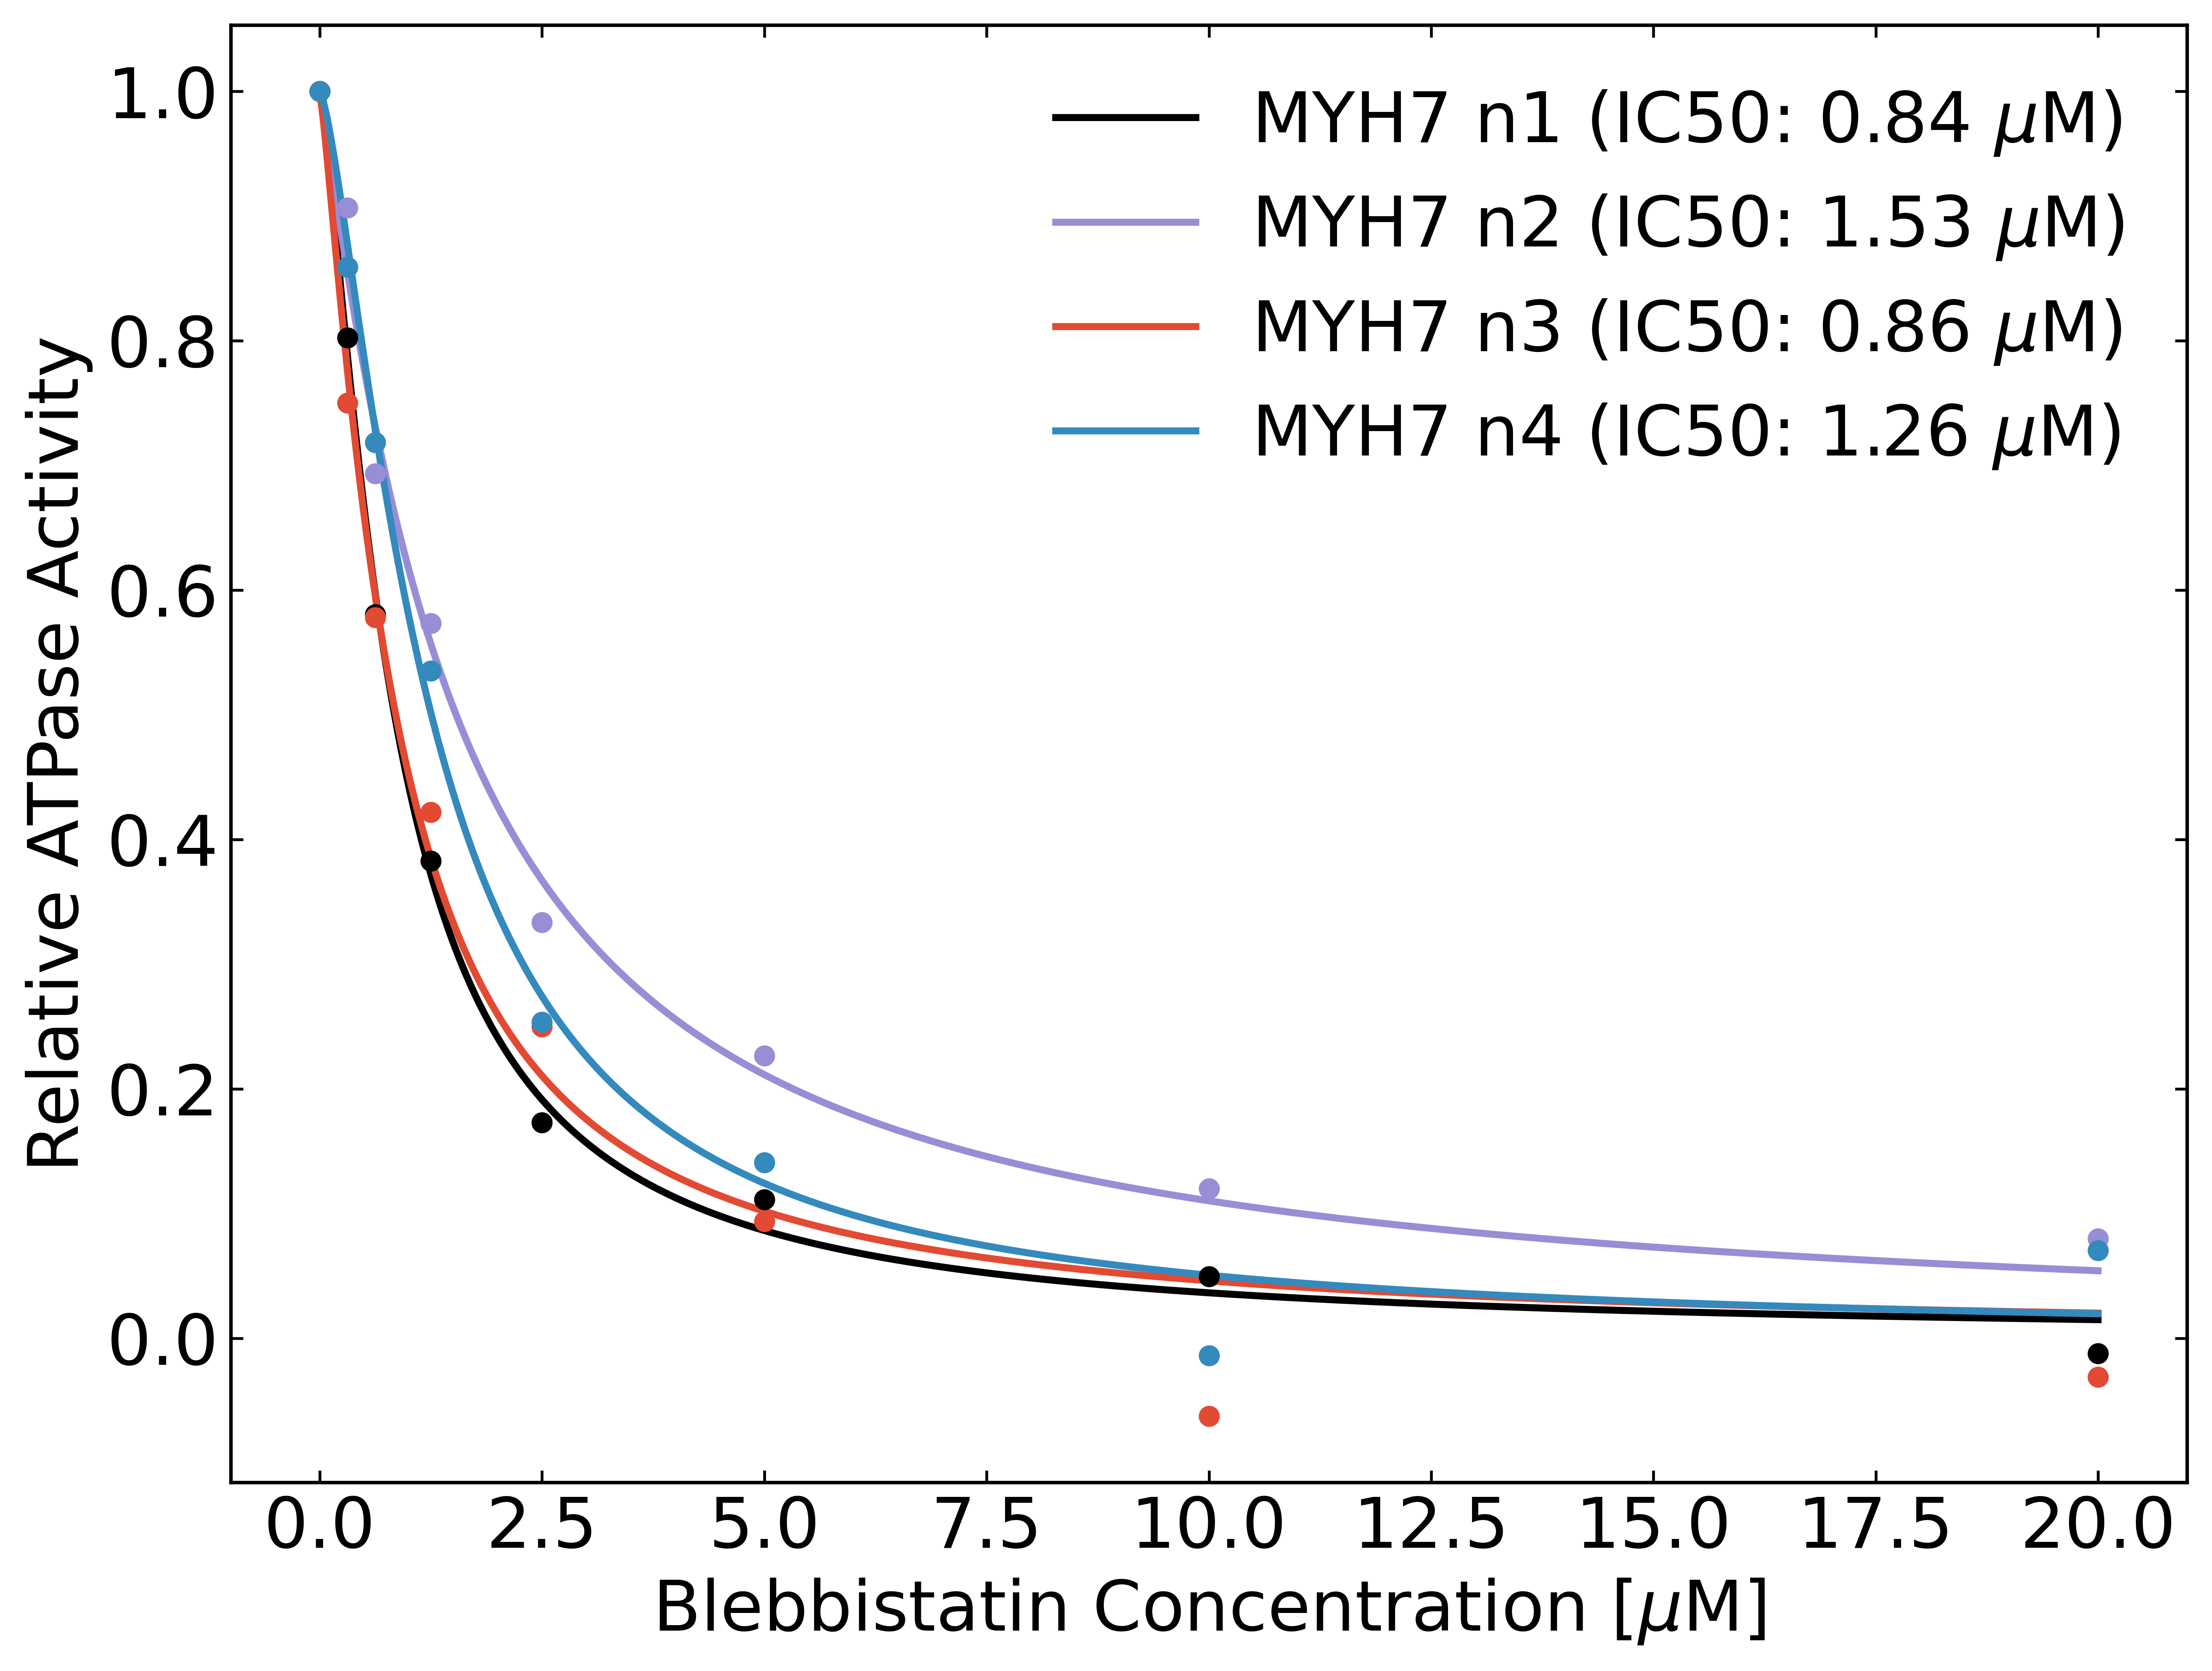

In [85]:
# Plot each curve individually
i = 0
for df in normalized_experiments:
    if len(df) == 3:
        continue
    p = plt.errorbar(df['Concentration'].iloc[::-1],
                 df['n_ATPase'].iloc[::-1],
                 fmt='o', markersize=5)
    
    x_concentrations = np.linspace(0, 20, 500)
    plt.plot(x_concentrations,
             ic50_equation_relative_activity(x_concentrations, myh7_IC50s[i], Ns[i]),
             label=f'MYH7 n{i+1} (IC50: {myh7_IC50s[i]:.2f} $\mu$M)', color=p[0].get_color())
    i += 1
    
plt.legend()
plt.xlabel('Blebbistatin Concentration [$\mu$M]')
plt.ylabel('Relative ATPase Activity')
plt.show()


In [148]:
# Merge experiments into single dataframe
combined_experiments = pd.merge(normalized_experiments[0].loc[:, ['Concentration', 'n_ATPase']],
                                normalized_experiments[1].loc[:, ['Concentration', 'n_ATPase']],
                                on='Concentration', how='outer', suffixes=(None, '_1'))

for i in range(2, len(normalized_experiments)):
    combined_experiments = pd.merge(combined_experiments,
                                    normalized_experiments[i].loc[:, ['Concentration', 'n_ATPase']],
                                    on='Concentration', how='outer', suffixes=(None, f'_{i}'))

# combined_experiments = combined_experiments.rename(columns={'n_ATPase': 'n_ATPase_3'})
combined_experiments['mean_n_ATPase'] = combined_experiments.iloc[:, 1:].mean(axis=1)
combined_experiments['std_n_ATPase'] = (
    combined_experiments.iloc[:, 1:len(normalized_experiments)+1].std(axis=1)
)
combined_experiments

Concentration  n_ATPase  n_ATPase_1  n_ATPase_2  n_ATPase_3  n_ATPase_4  \
0        20.0000 -0.012346         NaN    0.080000   -0.031250    0.070423   
1        10.0000  0.049383    0.000000    0.120000   -0.062500   -0.014085   
2         5.0000  0.111111         NaN    0.226667    0.093750    0.140845   
3         2.5000  0.172840         NaN    0.333333    0.250000    0.253521   
4         1.2500  0.382716    0.230769    0.573333    0.421875    0.535211   
5         0.6250  0.580247         NaN    0.693333    0.578125    0.718310   
6         0.3125  0.802469         NaN    0.906667    0.750000    0.859155   
7         0.0000  1.000000    1.000000    1.000000    1.000000    1.000000   

   mean_n_ATPase  std_n_ATPase  
0       0.026707      0.056673  
1       0.018560      0.069320  
2       0.143093      0.059012  
3       0.252423      0.065542  
4       0.428781      0.135648  
5       0.642504      0.073826  
6       0.829573      0.068032  
7       1.000000      0.000000

In [149]:
p0 = [1, 1]
bounds = ((0, 0), (np.inf, np.inf))

popt, pocv = curve_fit(ic50_equation_relative_activity,
                       combined_experiments['Concentration'],
                       combined_experiments['mean_n_ATPase'],
                       p0=p0, bounds=bounds)

overall_IC50 = popt[0]
overall_n = popt[1]

print(overall_IC50, overall_n)

1.0243388866729943 1.263440220006347


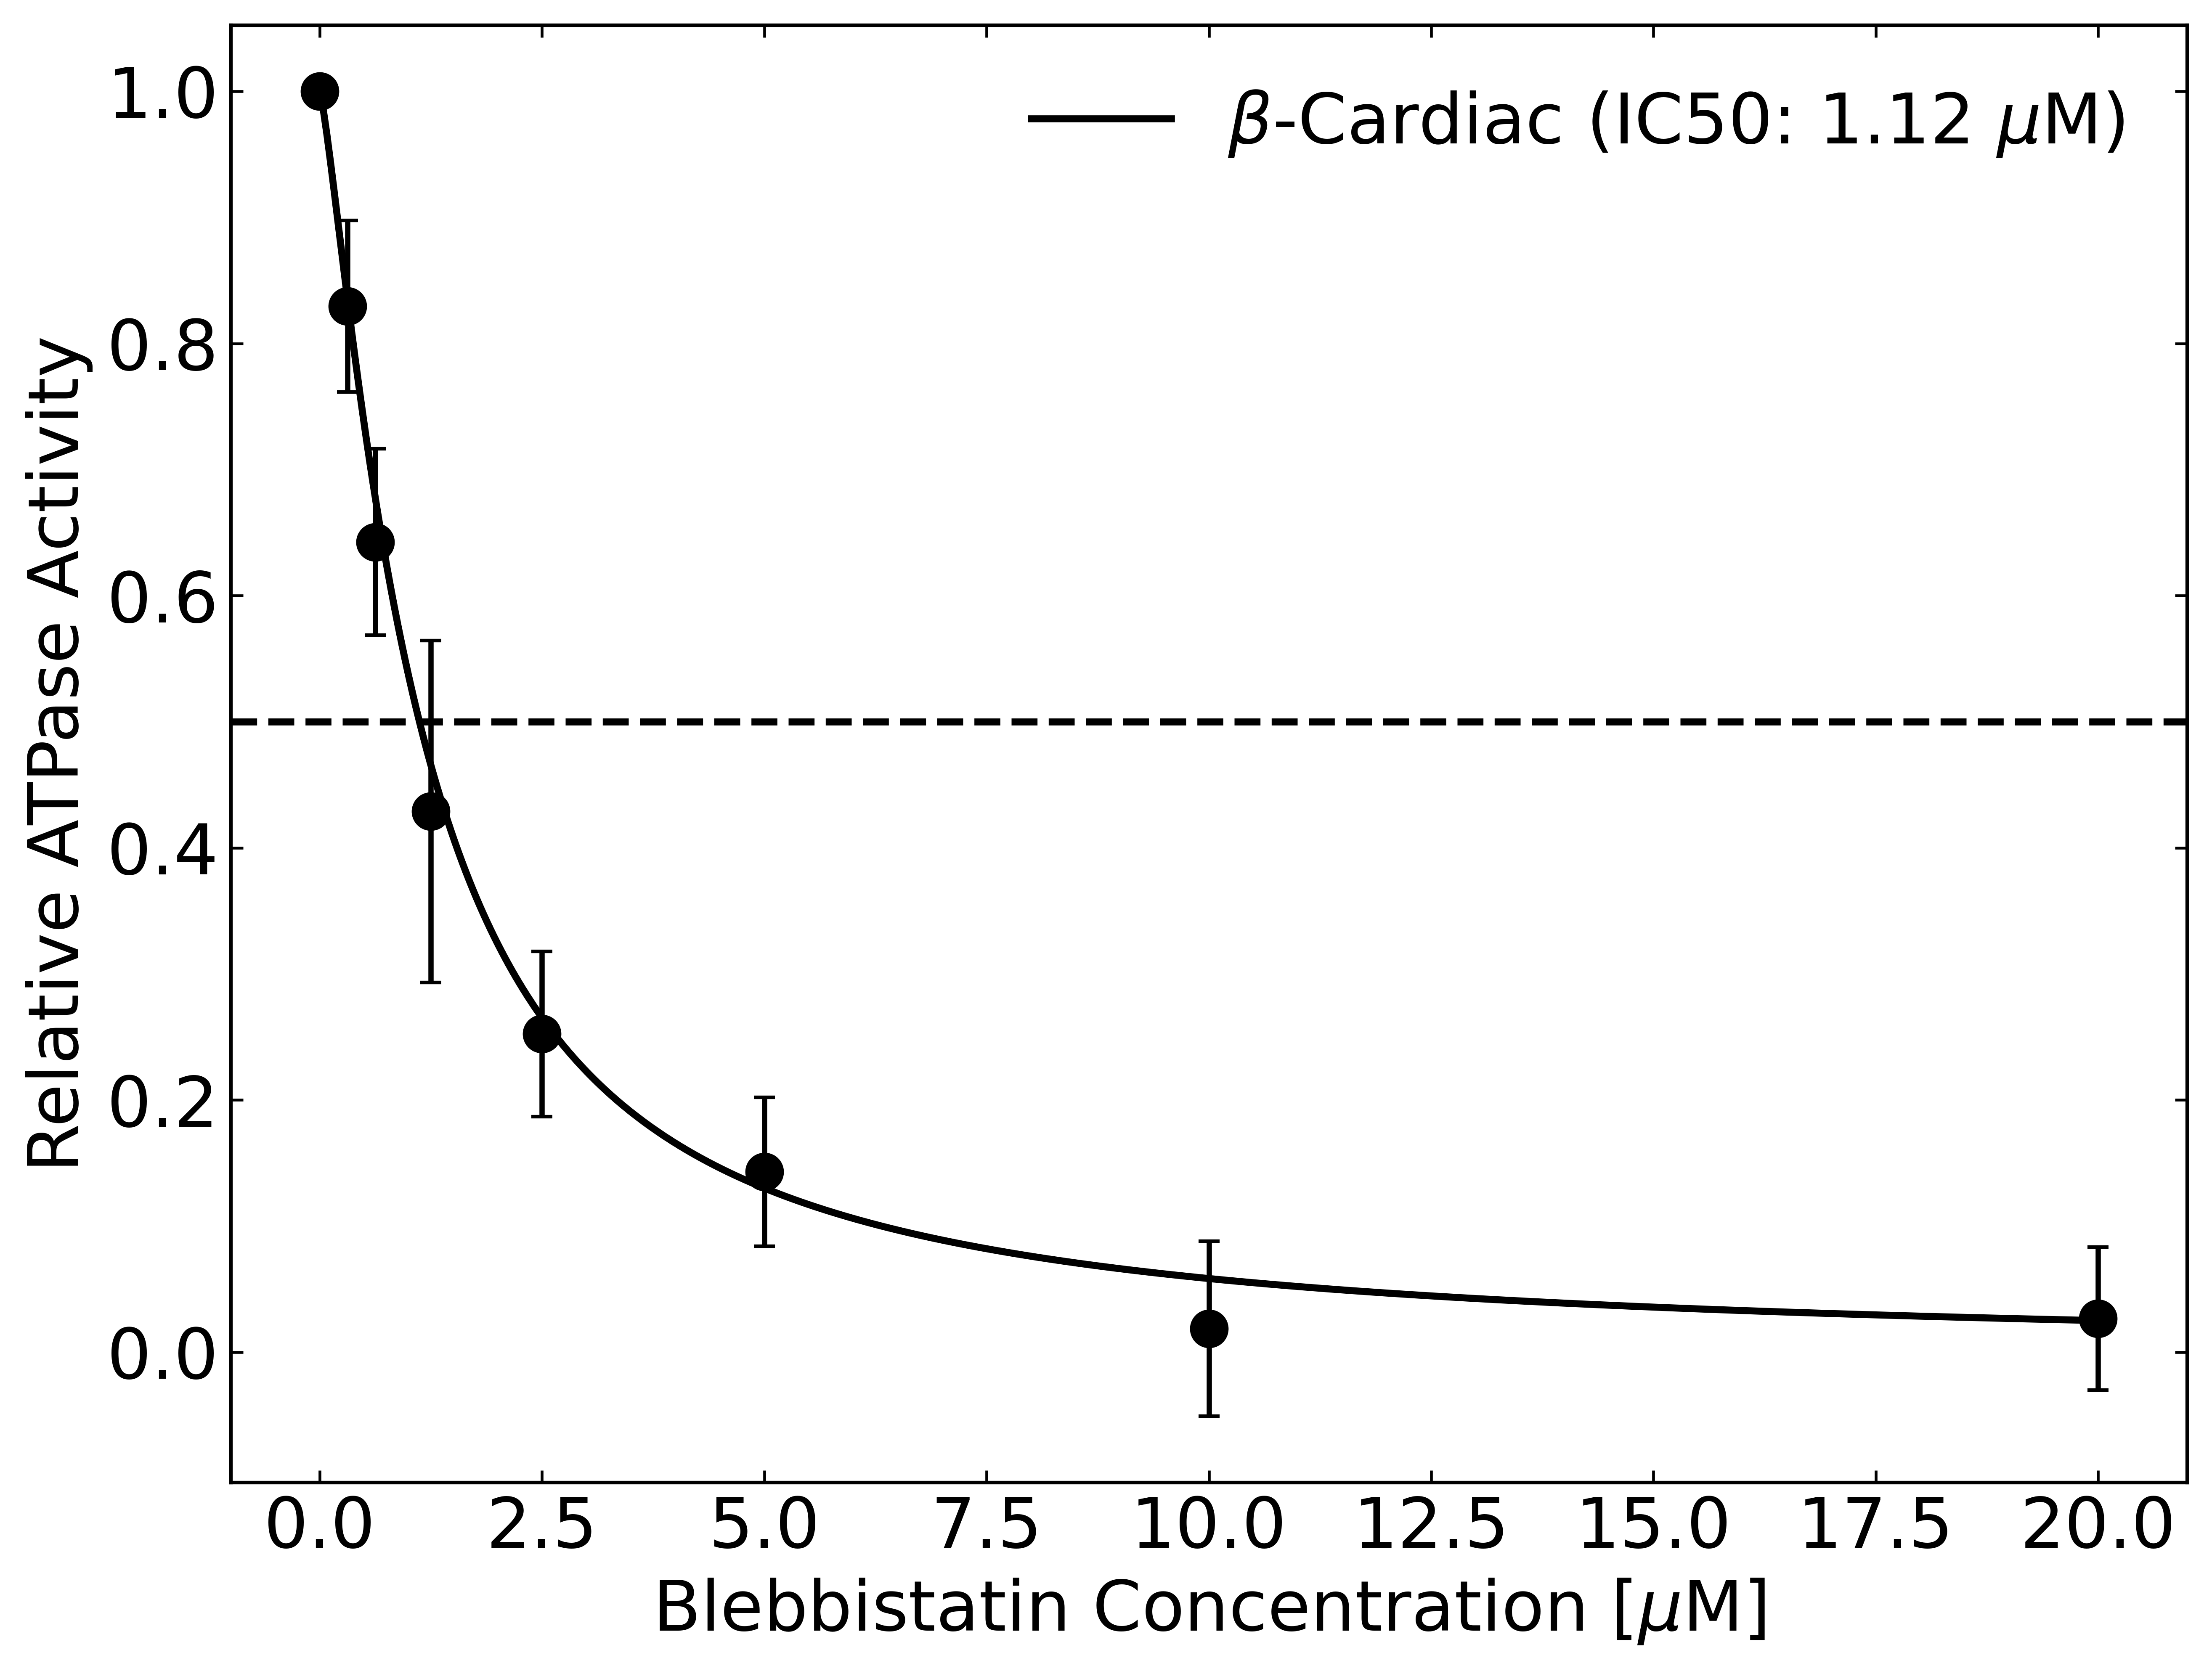

In [151]:
plt.errorbar(combined_experiments['Concentration'],
             combined_experiments['mean_n_ATPase'],
             combined_experiments['std_n_ATPase'], fmt='o', markersize=10, ecolor = 'k', 
             elinewidth = 1.5, capsize = 3, markeredgecolor = 'k')

x_concentrations = np.linspace(0, 20, 500)
plt.plot(x_concentrations,
         ic50_equation_relative_activity(x_concentrations, np.mean(myh7_IC50s), np.mean(Ns)),
         label=r'$\beta$-Cardiac' + f' (IC50: {np.mean(myh7_IC50s):.2f} $\mu$M)')

plt.xlabel('Blebbistatin Concentration [$\mu$M]', fontsize=20)
plt.ylabel('Relative ATPase Activity', fontsize=20)
plt.legend()

# plt.legend(fontsize=15)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.ylim((0, 1.05))
# plt.xlim((0, 100))

plt.axhline(0.5, color='black', linestyle='--')

plt.savefig('../experimental-data/myh7-blebbistatin-ic50-curve-relative-activity.png', dpi=300)
plt.savefig('../figures/specificity/supplement/myh7-blebbistatin-ic50-curve-relative-activity.png', dpi=300)
plt.show()

# IC50 Comparison

In [91]:
from scipy.stats import ttest_ind

In [93]:
myh7b_IC50s, myh7_IC50s

([0.344847904120722,
  0.5195794451111359,
  0.33962841105949737,
  0.26782576423628063,
  0.32321367424609687],
 [0.8417045665761781,
  1.5343283017222749,
  0.8556801245811823,
  1.2559271782937844])

In [95]:
ttest_ind(myh7b_IC50s, myh7_IC50s, equal_var=False)

Ttest_indResult(statistic=-4.410586961851873, pvalue=0.016735262519548096)

# Fit with fixed n in Hill Equation

In [33]:
# We fit to the mean ATPasee values for each concentration
p0 = [1]
bounds = ((0), (np.inf))
popt, pocv = curve_fit(ic50_equation_fixed_n,
                       experimental_data['uM'],
                       experimental_data.iloc[:, 3:5].mean(axis=1),
                       p0=p0, bounds=bounds)

IC_50 = popt[0]

print(f'IC50: {popt[0]:.2f}')

IC50: 24.00


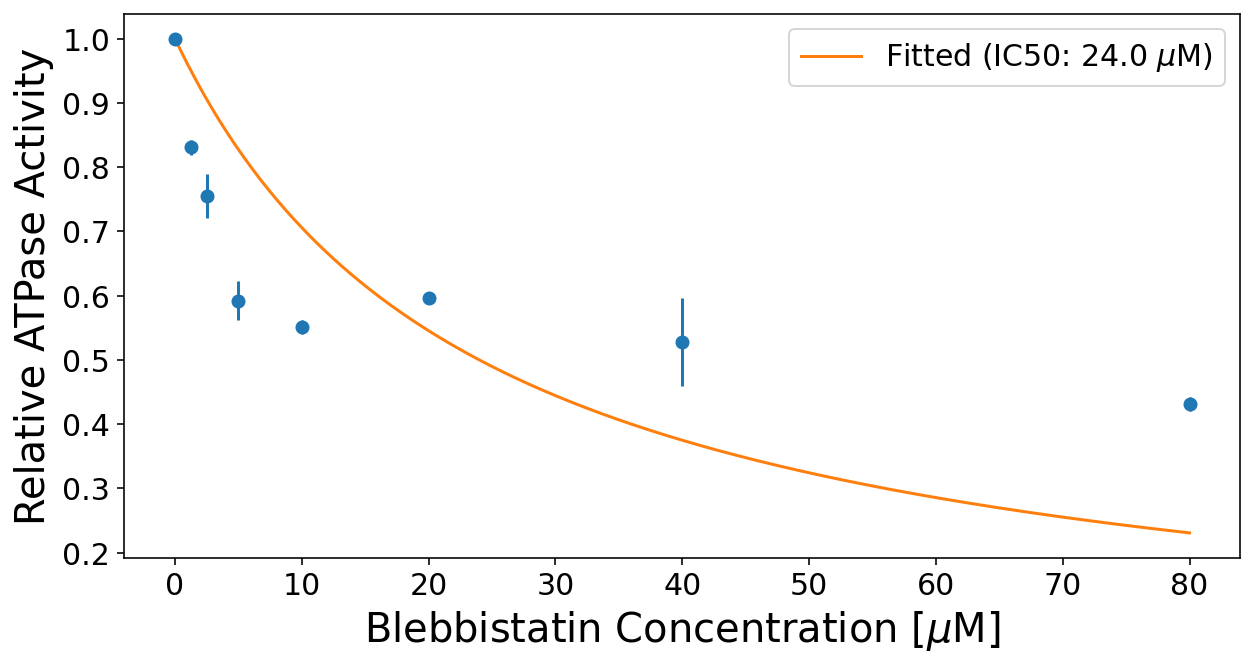

In [37]:
plt.errorbar(experimental_data['uM'], experimental_data.iloc[:, 3:5].mean(axis=1),
             experimental_data.iloc[:, 3:5].std(axis=1) / np.sqrt(2), fmt='o')

x_concentrations = np.linspace(0, 80, 500)
plt.plot(x_concentrations,
         ic50_equation_fixed_n(x_concentrations, IC_50), label=f'Fitted (IC50: {IC_50:.1f} $\mu$M)')

plt.xlabel('Blebbistatin Concentration [$\mu$M]', fontsize=20)
plt.ylabel('Relative ATPase Activity', fontsize=20)
plt.legend(fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [118]:
np.var(experimental_data.iloc[2,1:4])

0.0005268888888888888

In [120]:
experimental_data.iloc[2,1:4].describe()

count    3.000000
mean     0.077667
std      0.028113
min      0.059000
25%      0.061500
50%      0.064000
75%      0.087000
max      0.110000
Name: 2, dtype: float64

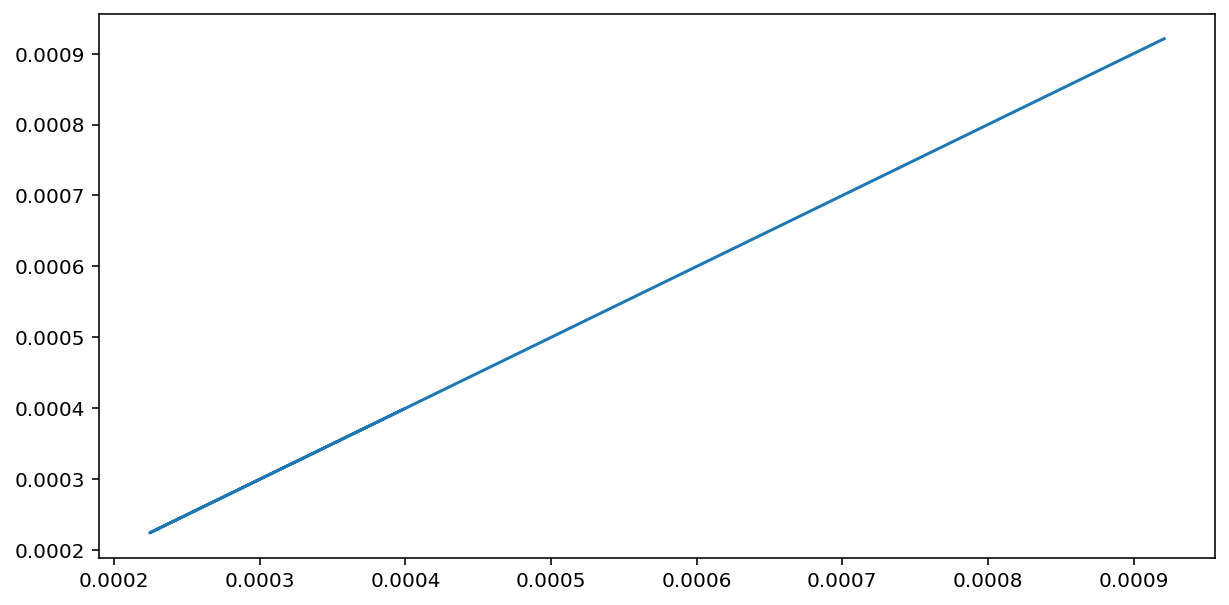

In [108]:
plt.plot(experimental_data.iloc[:, 1:4].std(axis=1) ** 2, experimental_data.iloc[:, 1:4].var(axis=1))

In [89]:
np.mean(IC50s), np.std(IC50s), np.var(IC50s)

(3.4820847396955785, 0.4247517292475372, 0.18041403149877314)

In [57]:
hill_equation(experimental_data['Concentration'], np.mean(As), np.mean(IC50s), np.mean(Ns), np.mean(baseline_activities))

0    0.054942
1    0.063204
2    0.078936
3    0.099160
4    0.115218
5    0.123768
6    0.127376
7    0.129526
Name: Concentration, dtype: float64